# DATATHLON 2023 - BTK (Troia's Notebook)

Üyeler: 

Semih Sarı (ÇOMÜ Bilgisayar Mühendisliği 4. sınıf lisans öğrencisi) 

Dr. Ulya Bayram (ÇOMÜ Dr. Öğretim Üyesi @ Elektrik-Elektronik Mühendisliği). 

Çanakkale Onsekiz Mart Üniversitesi'nden katıldığımız için bu yarışmaya, grubumuza Troia adını uygun gördük :)

![TROIA](https://www.getsupport.co.uk/wp-content/uploads/2020/12/trojan-horse.jpg)

fotoğraf referansı: https://www.getsupport.co.uk/wp-content/uploads/2020/12/trojan-horse.jpg

### Gerekli Kütüphaneler

In [ ]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

!pip install catboost
!pip install lightgbm
!pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

SEED = 17 # Çanakkale'nin plakası :)

DIR_ = "/work/" # Dosyaların directory'sini burada global variable olarak belirliyoruz
# Ortak kod yazabilmek için Kaggle'a ek olarak Deepnote.com'u da kullanmıştık. O nedenle bu dir_ hangi
# ortamı kullandığınıza göre değişecek

TARGET = "Öbek İsmi" # hedefimiz (yani label'lar) bu kolon

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
def prepare_df(df):

    """
        index kolonu siliniyor default olarak.
        Hem training hem test için lazım olacak
    """
    
    df.drop(columns=["index"], axis=1, inplace = True)

    return df
 

## 1) GÖRSEL VERİ ANALİZİ ve ANLAMLANDIRMA ÇALIŞMASI

### 1.1) Yardımcı Fonksiyonlar Sınıfı

In [ ]:
class DataframeAnalyzer:

    def __init__(self, dataframe):

        self.df = dataframe

        # bir de kolonları burada ayıp self'e ekleyelim, diğer fonksiyonlara lazım
        self.categorical_cols, self.numerical_cols = self.get_column_names()

    def get_column_names(self):
        """
            kolonları categorical ve numerical diye ayırıyoruz
            
            output: categorical kolonların isimleri listesi, numerical kolonların isimleri listesi
        """
        categorical_cols = [col for col in self.df.columns if self.df[col].dtypes == "O"]
        categorical_cols.remove(TARGET)

        numerical_cols = [col for col in self.df.columns if self.df[col].dtypes != "O"]

        print(f'Number of categorical_cols: {len(categorical_cols)}')
        print(f'Number of numerical_cols: {len(numerical_cols)}')

        return categorical_cols, numerical_cols
    
    def get_categorical_cols(self):
        """
            amacım istendiği zaman bu categorical kolonları vermek
        """
        return self.categorical_cols

    def get_numerical_cols(self):
        """
            amacım istendiği zaman bu numerical kolonları vermek
        """
        return self.numerical_cols

    def print_df(self):
        """
            fonksiyonun görevi standart bilgileri print etmek
        """
        
        print("Dataframe Shape:\n--------------")
        print(self.df.shape)
        
        print("\nValue Types:\n-------------")
        print(self.df.dtypes)
        
        print("\nNumber of null's per column:\n--------------------")
        print(self.df.isnull().sum())
        
        print("\nDescriptive Statistics:\n--------------")
        desc_stats = self.df.describe()
        print(desc_stats.T)
        
    def summarize_cat_columns(self):
        print("\nCategorical Column Summaries:\n---------------")

        # Create a sorted list of target names
        sorted_target_names = sorted(training_df[TARGET].unique())

        for cat_col in self.categorical_cols:
            print(f"\n----- {cat_col} -----")
            print(self.df[cat_col].value_counts())
            print("Ratio:\n------\n", self.df[cat_col].value_counts() / len(self.df))

            plt.figure(figsize=(12, 8))
            happy_colors = ['#FFC300', '#AFEEEE', '#FF0000', '#191970', '#FF1493', '#4CAF50', '#3498DB', '#9B59B6']
            sns.set_palette(happy_colors)
            ax = sns.countplot(x=cat_col, data=training_df, hue=TARGET, 
                                hue_order=sorted_target_names, linewidth=1.5, edgecolor="black")
            # Set vertical gridlines
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            plt.title(f"{cat_col} Dağılımı", fontsize=16)
            plt.xlabel(cat_col, fontsize=15)
            plt.ylabel("Kişi sayısı", fontsize=15)
            plt.xticks(rotation=45)
            # Change x and y-axis tick label font size
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

            sns.despine()
            plt.tight_layout()

            # Lejantı grafiğin dışına taşı
            plt.legend(title=TARGET, title_fontsize=18, fontsize=15, bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.show()

    def summarize_num_columns(self):   
        print("\nNumerical Column Summaries:\n----------------")

        # Create a sorted list of target names
        sorted_target_names = sorted(training_df[TARGET].unique())

        for num_col in self.numerical_cols:
            print(f"\n----- {num_col} -----")
            print("Min:", self.df[num_col].min())
            print("Mean:", self.df[num_col].mean())
            print("Median:", self.df[num_col].median())
            print("Max:", self.df[num_col].max())
            print("Std Dev:", self.df[num_col].std())

            # Set style and palette
            sns.set(style="whitegrid")
            happy_colors = ['#FFC300', '#AFEEEE', '#FF0000', '#ADFF2F', '#FF1493', '#4CAF50', '#3498DB', '#9B59B6']
            sns.set_palette(happy_colors)

            # Create a violin plot
            plt.figure(figsize=(14, 8))
            ax = sns.violinplot(x=TARGET, y=num_col, data=self.df, inner="quartile", 
                                linewidth=2, order=sorted_target_names)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            # Set title and labels
            plt.title(f'Distribution of {num_col}', fontsize=16)
            plt.xlabel(TARGET, fontsize=15)
            plt.ylabel(num_col, fontsize=15)

            # Change x and y-axis tick label font size
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

            # Rotate x-axis labels for better readability
            plt.xticks(rotation=45, ha='right')

            # Adjust plot layout
            sns.despine(trim=True)
            plt.tight_layout()

            # Show the plot
            plt.show()


    def show_correlation_matrix(self):
        print("\nCorrelation Matrix:\n-----------------")
        corr_matrix = self.df.corr()
        
        # Create a heatmap using seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title("Correlation Matrix Heatmap of Training")
        plt.show()
    
    def get_target_summary(self):
        """
        Target (hedef değişken) ile farklı categorical ve numerical featurelar arasındaki ilişkiyi gösteren 
        bir özet raporu oluşturur: target değişkenin ortalama değerlerini çeşitli 
        categorical ve numerical kolonlara (yani feature'lara) göre gruplayarak sunar.

        """
        print("\n---------- Numerical Columns vs Target (Öbek İsmi) ----------\n")
        print(self.df.groupby(TARGET).agg({self.numerical_cols: "mean"}), end="\n")
        print("\n---------- Categorical Columns vs Target (Öbek İsmi) ----------\n")
        print(pd.DataFrame({"TARGET_MEAN": self.df.groupby(self.categorical_cols)[TARGET].mean()}), end="\n")



### 1.2) Training verilerinin istatistiksel ve görsel analizi

In [ ]:
# Dataset'in training setini okuyup analize başlıyoruz
training_df = pd.read_csv(DIR_ + "train.csv")
training_df = prepare_df(training_df)

print(training_df.head())
print("\n")

analyzer = DataframeAnalyzer(training_df)

  Cinsiyet Yaş Grubu Medeni Durum         Eğitim Düzeyi                 İstihdam Durumu  Yıllık Ortalama Gelir Yaşadığı Şehir     En Çok İlgilendiği Ürün Grubu  Yıllık Ortalama Satın Alım Miktarı  Yıllık Ortalama Sipariş Verilen Ürün Adedi Eğitime Devam Etme Durumu Öbek İsmi  Yıllık Ortalama Sepete Atılan Ürün Adedi
0    Kadın     31-40        Bekar  Yüksek Lisans Mezunu  Düzenli ve Ücretli Bir İşi Var          748266.440879    Büyük Şehir  Elektronik ve Teknolojik Ürünler                        32010.900881                                   37.310644                   Etmiyor    obek_4                                102.936904
1    Erkek       >60         Evli           Lise Mezunu             Kendi İşinin Sahibi          246298.609605    Küçük Şehir                  Spor Malzemeleri                         4145.729891                                   11.554851                   Etmiyor    obek_5                                 82.176053
2    Erkek     18-30        Bekar           Li

In [ ]:
analyzer.print_df()

Dataframe Shape:
--------------
(5460, 13)

Value Types:
-------------
Cinsiyet                                       object
Yaş Grubu                                      object
Medeni Durum                                   object
Eğitim Düzeyi                                  object
İstihdam Durumu                                object
Yıllık Ortalama Gelir                         float64
Yaşadığı Şehir                                 object
En Çok İlgilendiği Ürün Grubu                  object
Yıllık Ortalama Satın Alım Miktarı            float64
Yıllık Ortalama Sipariş Verilen Ürün Adedi    float64
Eğitime Devam Etme Durumu                      object
Öbek İsmi                                      object
Yıllık Ortalama Sepete Atılan Ürün Adedi      float64
dtype: object

Number of null's per column:
--------------------
Cinsiyet                                      0
Yaş Grubu                                     0
Medeni Durum                                  0
Eğitim Düzeyi     

In [ ]:
# Kategorik ve numerik kolonların elde edilmesi
categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

### 1.2.1) Kategorik (categorical) kolonların analizi

In [ ]:
categorical_cols

['Cinsiyet',
 'Yaş Grubu',
 'Medeni Durum',
 'Eğitim Düzeyi',
 'İstihdam Durumu',
 'Yaşadığı Şehir',
 'En Çok İlgilendiği Ürün Grubu',
 'Eğitime Devam Etme Durumu']


Categorical Column Summaries:
---------------

----- Cinsiyet -----
Erkek    2964
Kadın    2496
Name: Cinsiyet, dtype: int64
Ratio:
------
 Erkek    0.542857
Kadın    0.457143
Name: Cinsiyet, dtype: float64


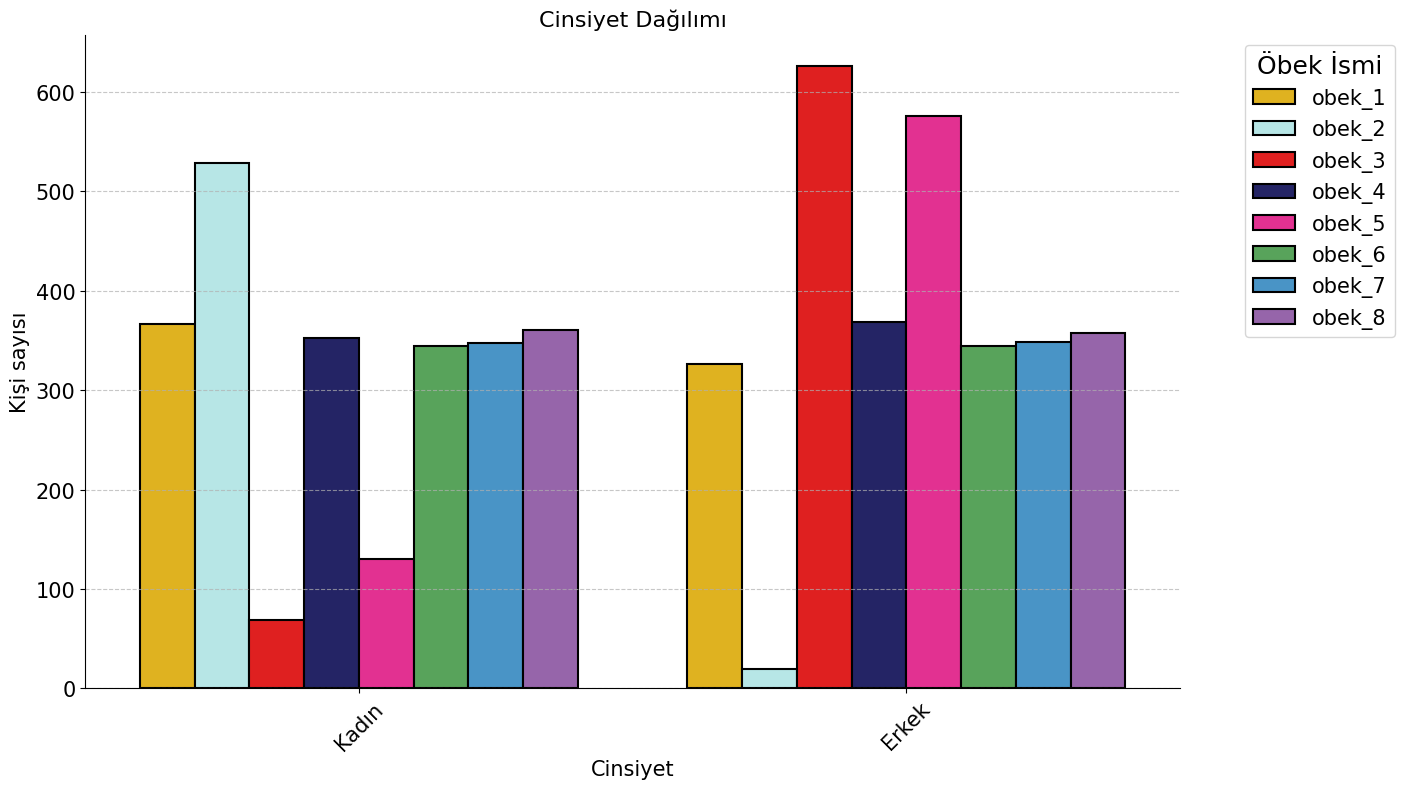


----- Yaş Grubu -----
18-30    1841
31-40    1477
51-60     861
41-50     727
>60       554
Name: Yaş Grubu, dtype: int64
Ratio:
------
 18-30    0.337179
31-40    0.270513
51-60    0.157692
41-50    0.133150
>60      0.101465
Name: Yaş Grubu, dtype: float64


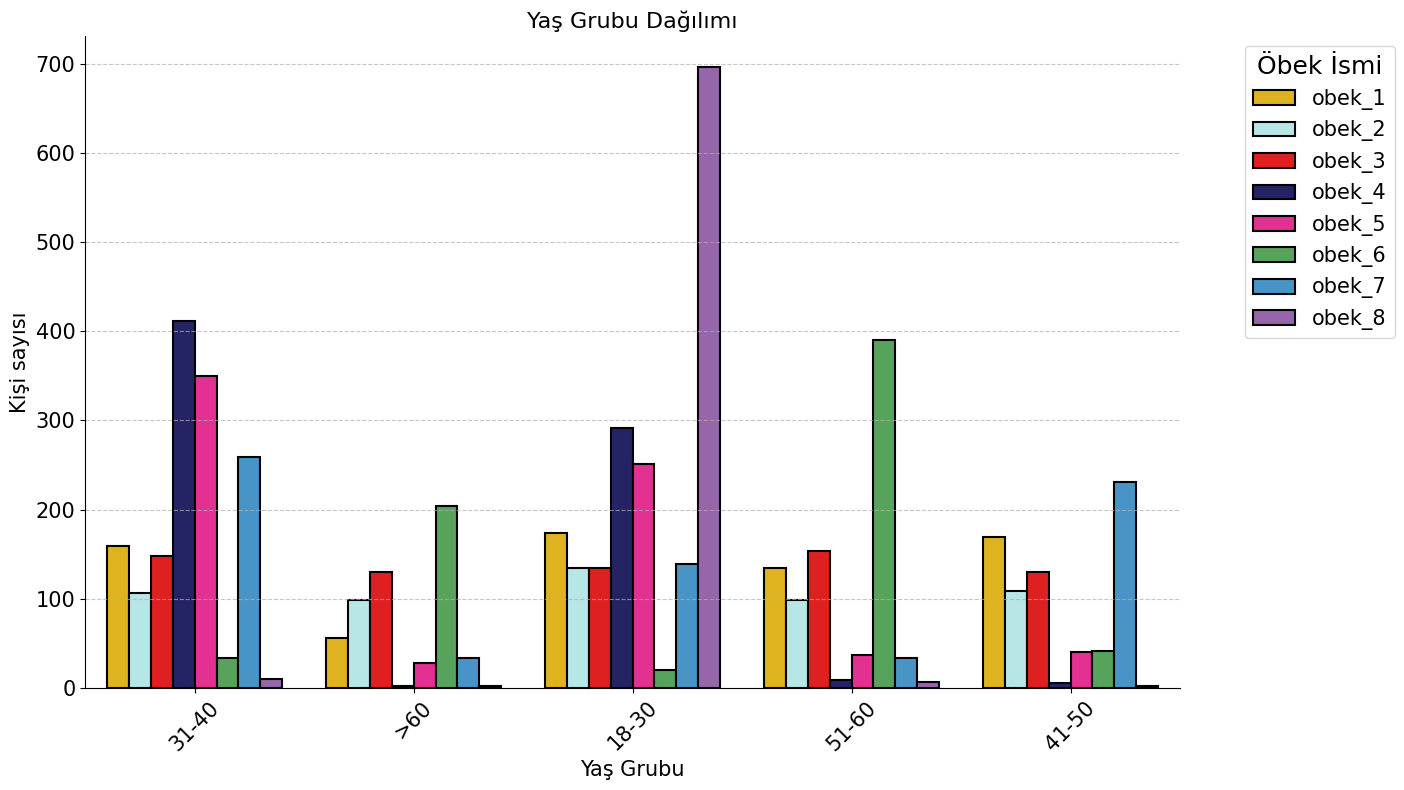


----- Medeni Durum -----
Evli     2834
Bekar    2626
Name: Medeni Durum, dtype: int64
Ratio:
------
 Evli     0.519048
Bekar    0.480952
Name: Medeni Durum, dtype: float64


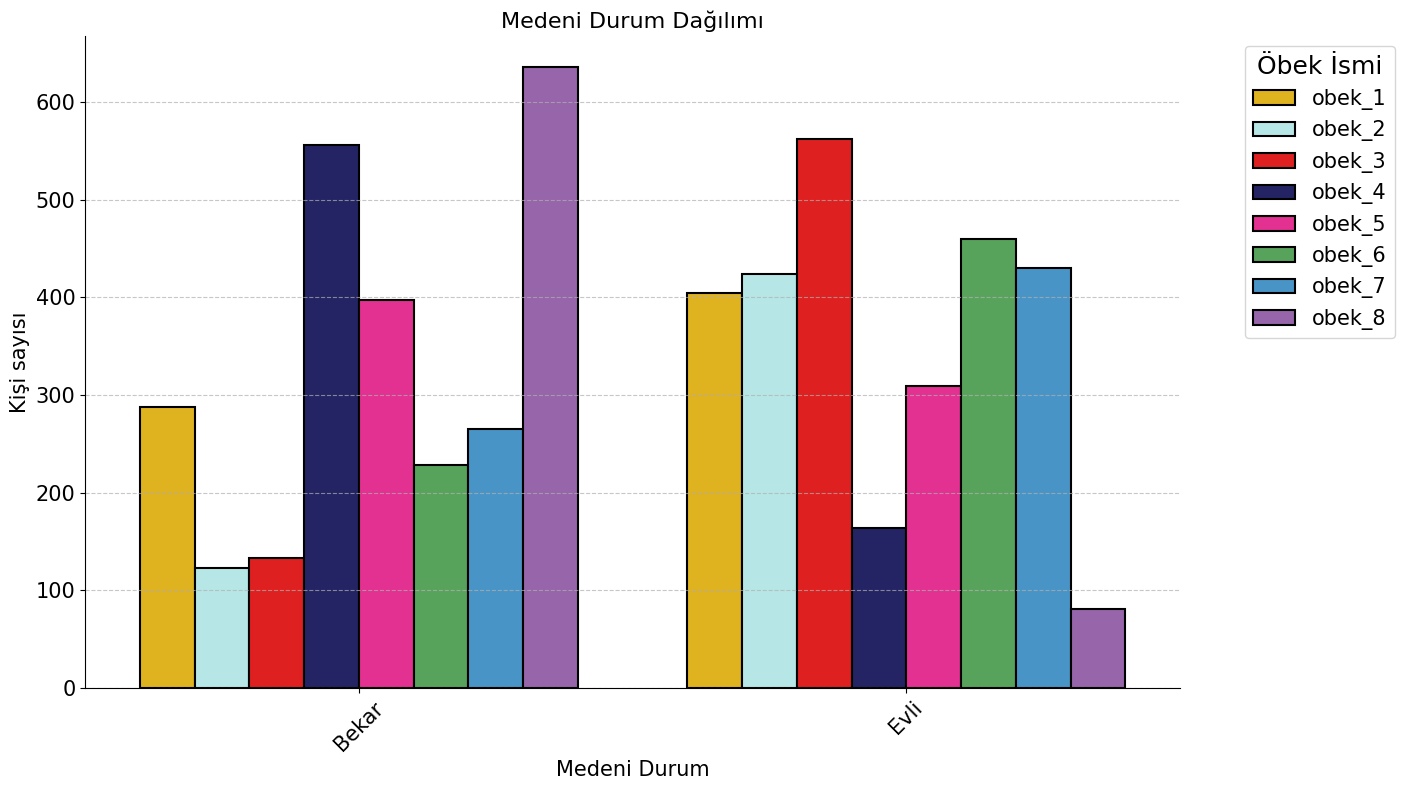


----- Eğitim Düzeyi -----
Lise Mezunu             1388
Üniversite Mezunu       1257
Yüksekokul Mezunu        588
Yüksek Lisans Mezunu     545
İlkokul Mezunu           417
Ortaokul Mezunu          412
Eğitimsiz                381
Doktora Mezunu           263
Doktora Ötesi            209
Name: Eğitim Düzeyi, dtype: int64
Ratio:
------
 Lise Mezunu             0.254212
Üniversite Mezunu       0.230220
Yüksekokul Mezunu       0.107692
Yüksek Lisans Mezunu    0.099817
İlkokul Mezunu          0.076374
Ortaokul Mezunu         0.075458
Eğitimsiz               0.069780
Doktora Mezunu          0.048168
Doktora Ötesi           0.038278
Name: Eğitim Düzeyi, dtype: float64


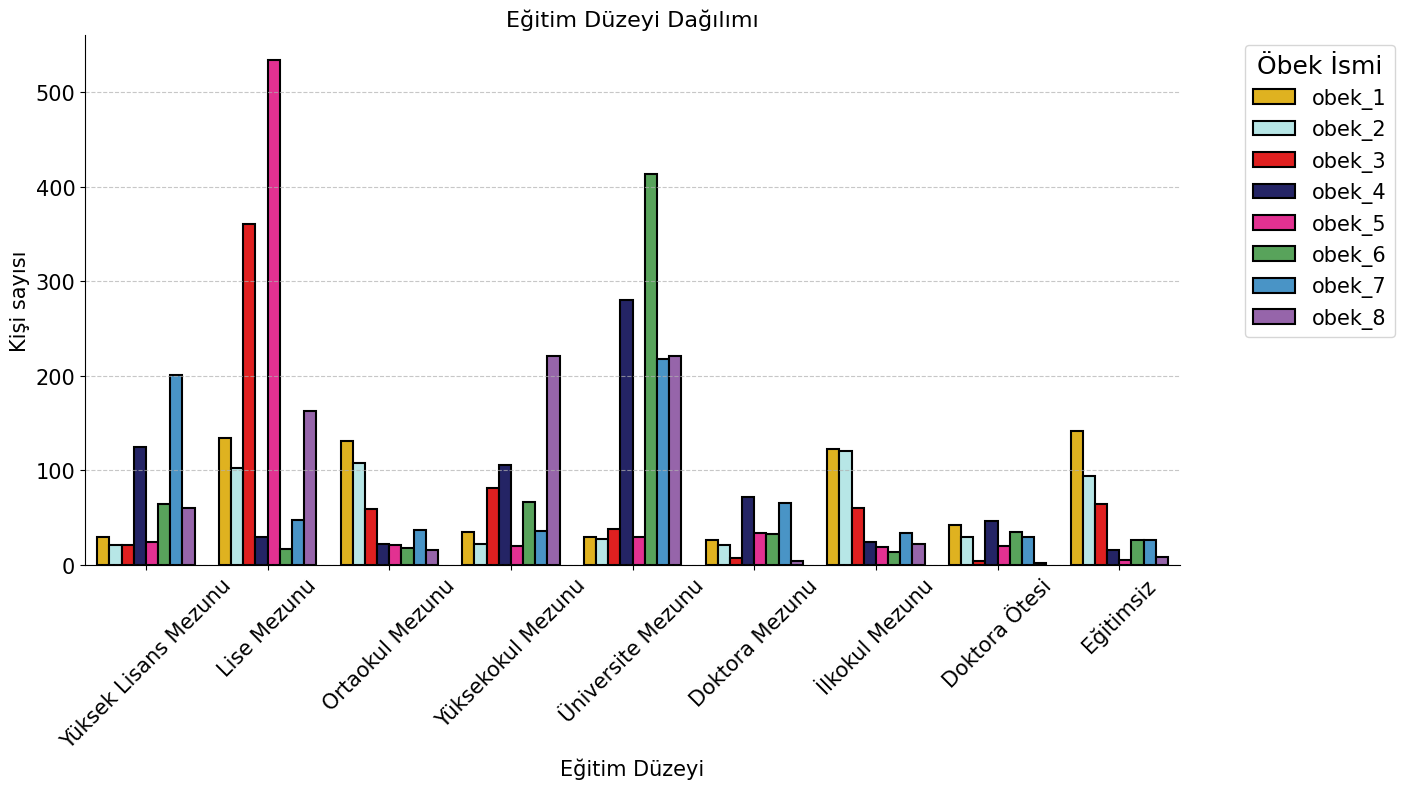


----- İstihdam Durumu -----
Düzenli ve Ücretli Bir İşi Var    2768
İşsiz veya Düzenli Bir İşi Yok    1349
Kendi İşinin Sahibi                879
Emekli                             464
Name: İstihdam Durumu, dtype: int64
Ratio:
------
 Düzenli ve Ücretli Bir İşi Var    0.506960
İşsiz veya Düzenli Bir İşi Yok    0.247070
Kendi İşinin Sahibi               0.160989
Emekli                            0.084982
Name: İstihdam Durumu, dtype: float64


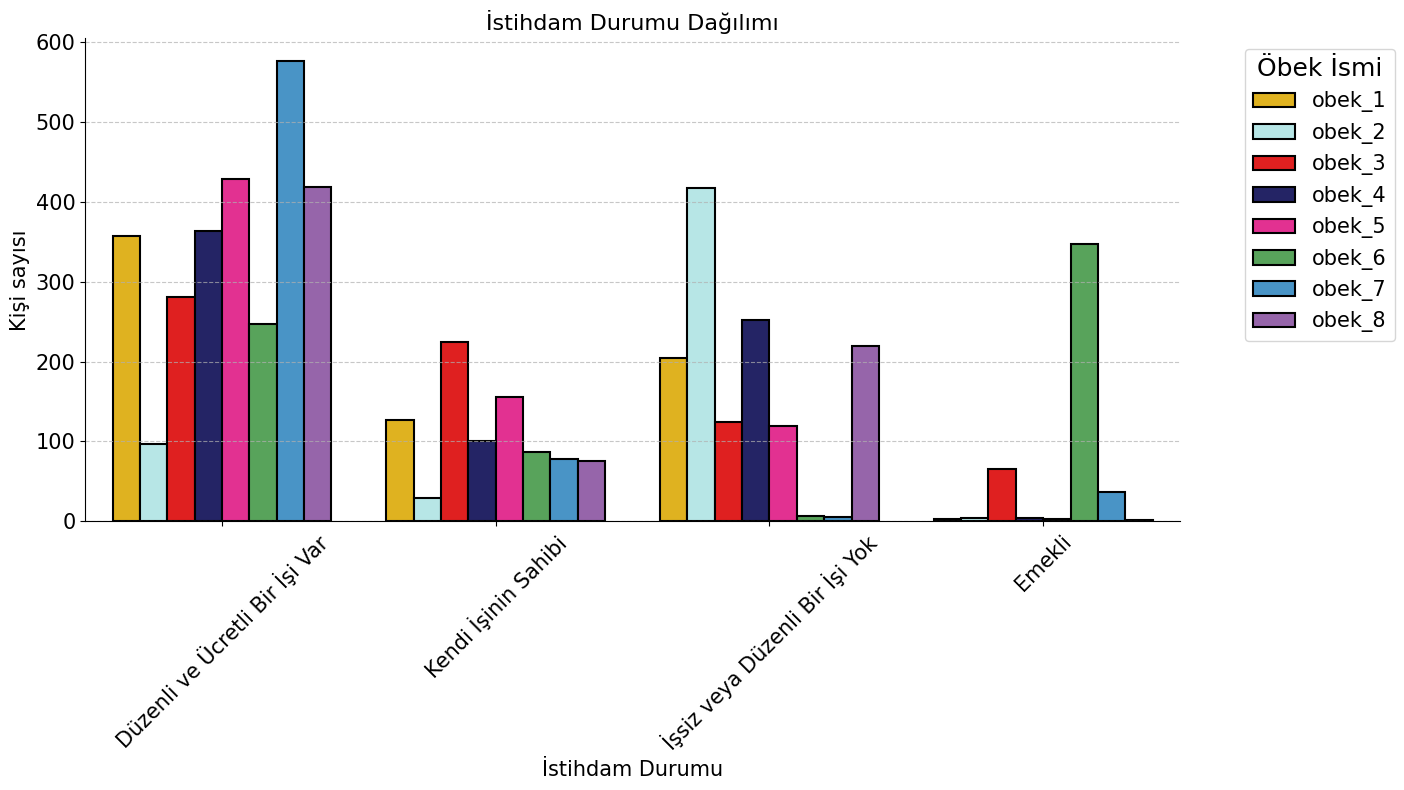


----- Yaşadığı Şehir -----
Büyük Şehir        1959
Küçük Şehir        1842
Köy veya Kasaba    1092
Kırsal              567
Name: Yaşadığı Şehir, dtype: int64
Ratio:
------
 Büyük Şehir        0.358791
Küçük Şehir        0.337363
Köy veya Kasaba    0.200000
Kırsal             0.103846
Name: Yaşadığı Şehir, dtype: float64


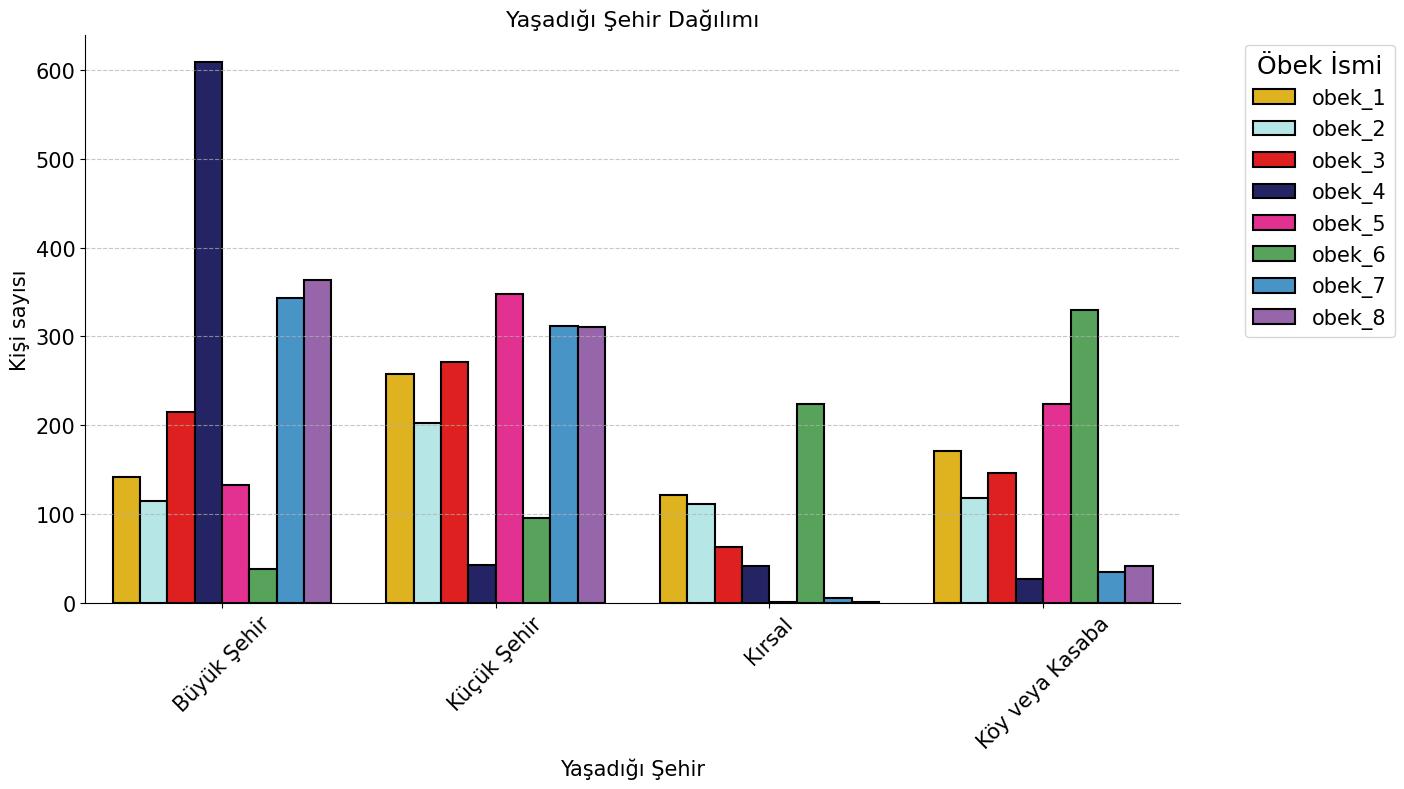


----- En Çok İlgilendiği Ürün Grubu -----
Giyim                               1487
Ev ve Mobilya                       1114
Elektronik ve Teknolojik Ürünler    1029
Spor Malzemeleri                    1001
Kozmetik                             829
Name: En Çok İlgilendiği Ürün Grubu, dtype: int64
Ratio:
------
 Giyim                               0.272344
Ev ve Mobilya                       0.204029
Elektronik ve Teknolojik Ürünler    0.188462
Spor Malzemeleri                    0.183333
Kozmetik                            0.151832
Name: En Çok İlgilendiği Ürün Grubu, dtype: float64


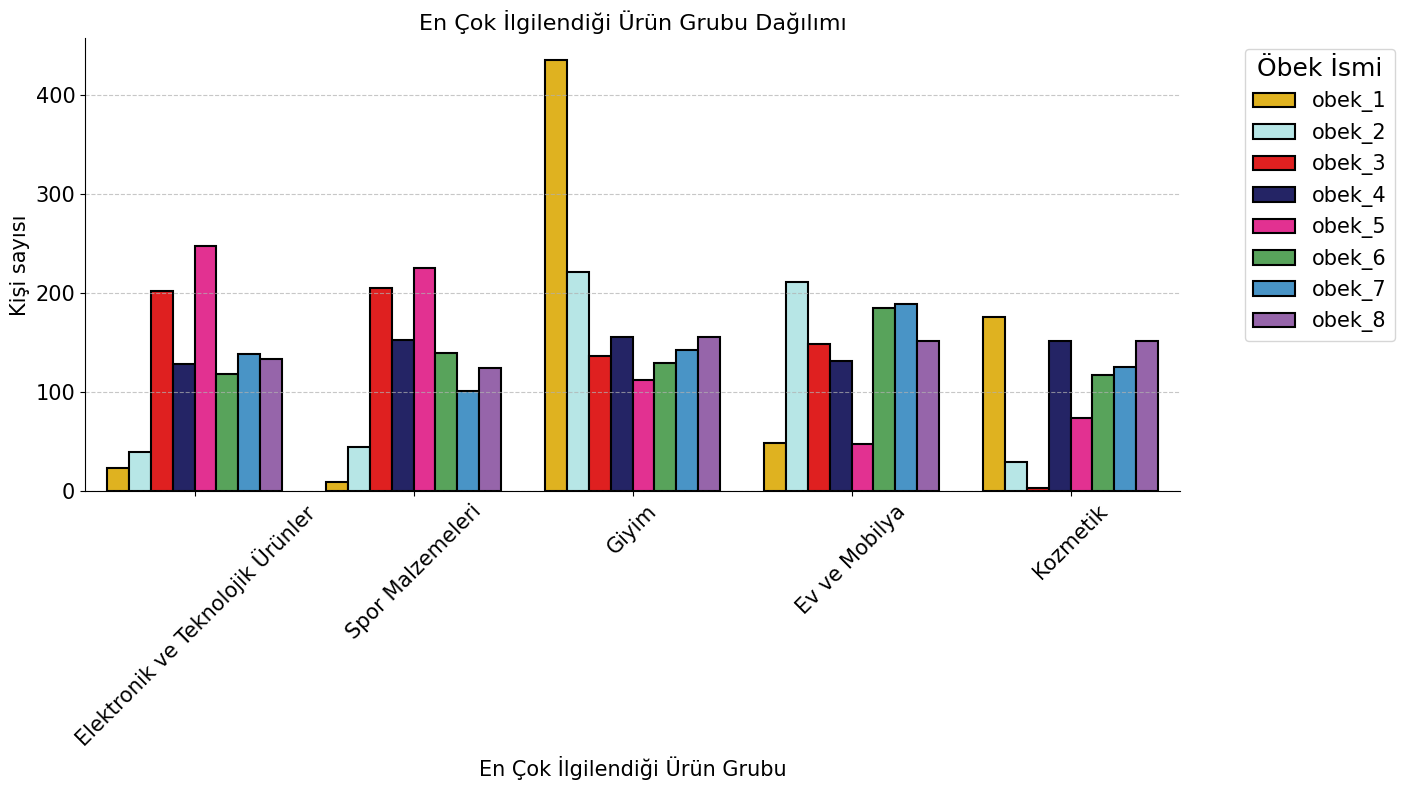


----- Eğitime Devam Etme Durumu -----
Etmiyor    4554
Ediyor      906
Name: Eğitime Devam Etme Durumu, dtype: int64
Ratio:
------
 Etmiyor    0.834066
Ediyor     0.165934
Name: Eğitime Devam Etme Durumu, dtype: float64


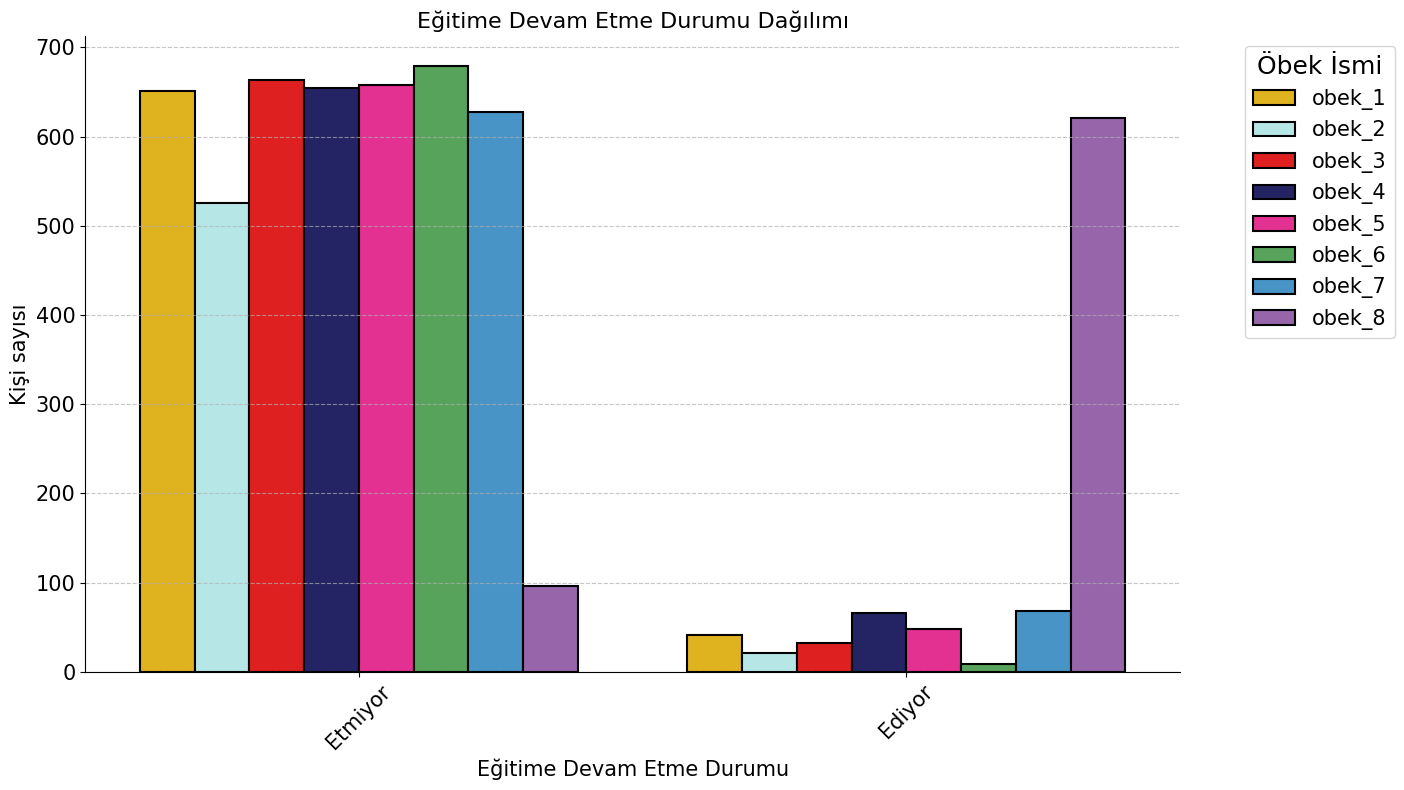

In [ ]:
analyzer.summarize_cat_columns()

Kategorik plotlar ve kişi sayılarına göre şu gözlemleri yaptık:

- Öbek 1 çoğunlukla giyim ve kozmetik alışverişi yapıyor, eğitim düzeyi düşük, yaşlar 60'tan genç.

- Öbek 2 çoğunlukla evli kadınlardan oluşuyor, giyim ve mobilya alışverişi yapıyorlar, eğitim düzeyi en fazla lise, genellikle işsiz, yaşlar 60'tan genç.

- Öbek 3 her yaştan evli erkekleri içeriyor, kozmetik hariç her şeyi alıyorlar, çoğu lise mezunu, kırsalda pek yaşamıyorlar.

- Öbek 4 bekar, 18-40 yaş arası, büyük şehirde yaşayan, en az yüksek okul mezunu, eğitimli kişileri kapsıyor. Her şeyi satın alıyorlar.

- Öbek 5 çoğu 18-40 yaş arası erkek, lise mezunu, kırsalda yaşamayan, aralarında emekli olmayan bir grup insan.

- Öbek 6 kırsal, köy ve kasabayı tercih ediyor, çoğu emekli, 51 yaş ve üstü, üniversite mezunu insanlar.

- Öbek 7 küçük ve büyük şehirlerde yaşıyor, en az üniversite mezunu, düzenli işi var, 18-50 yaş arasında.

- Öbek 8 eğitime devam eden genç kesim.

### 1.2.2) Numerik (numerical) kolonların analizi

In [ ]:
numerical_cols

['Yıllık Ortalama Gelir',
 'Yıllık Ortalama Satın Alım Miktarı',
 'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
 'Yıllık Ortalama Sepete Atılan Ürün Adedi']


Numerical Column Summaries:
----------------

----- Yıllık Ortalama Gelir -----
Min: 43922.98869298681
Mean: 363571.1334275545
Median: 286925.4360734618
Max: 1192437.1452577456
Std Dev: 219714.4424073492


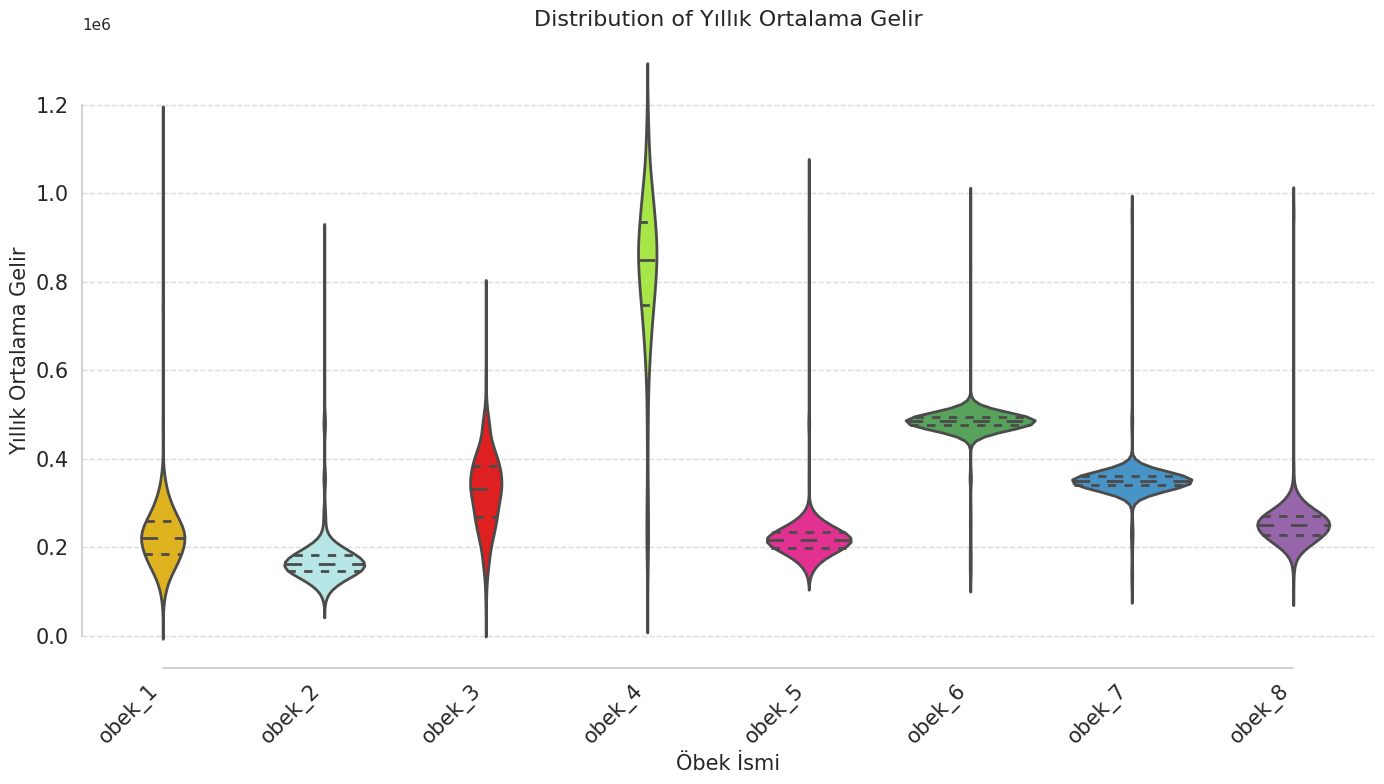


----- Yıllık Ortalama Satın Alım Miktarı -----
Min: 2859.2540004923017
Mean: 16616.612217082475
Median: 8426.818967242809
Max: 48605.59441519324
Std Dev: 14099.171703975773


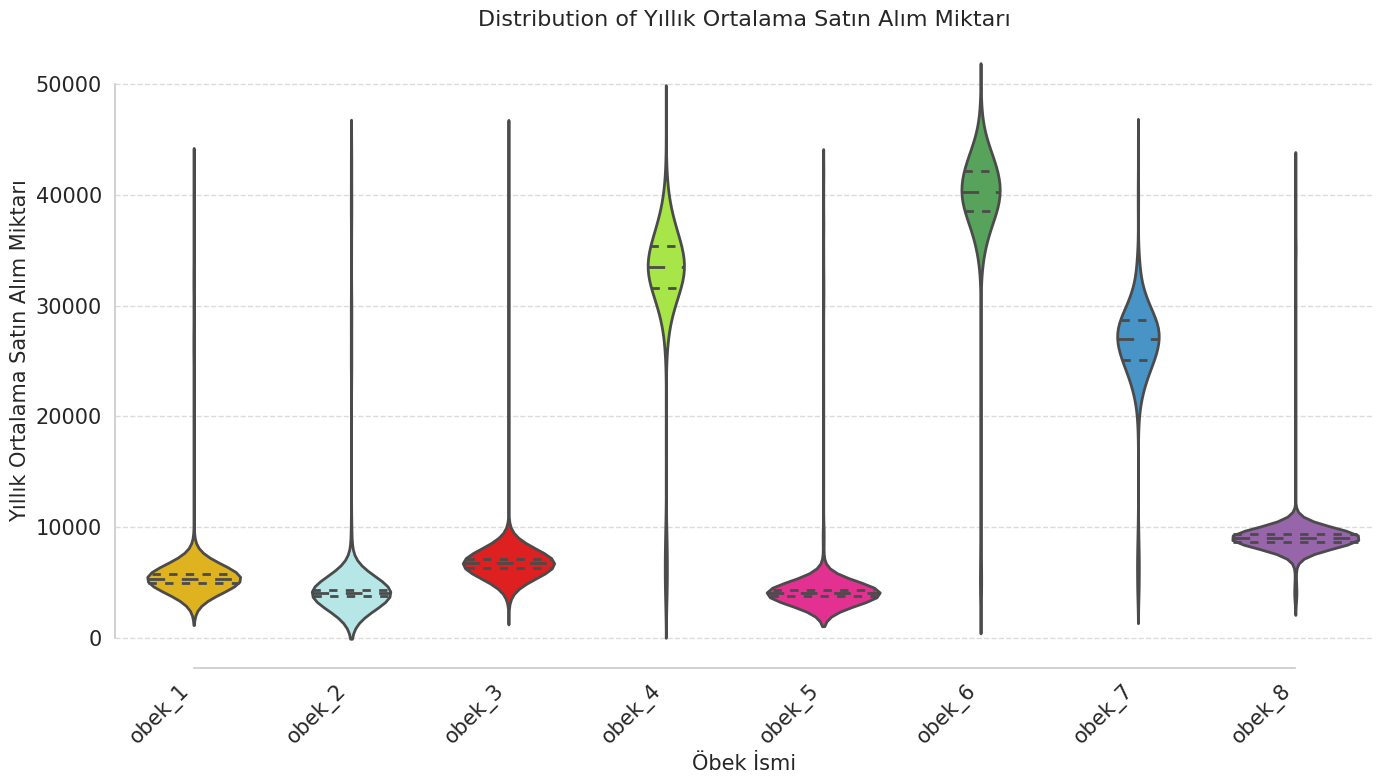


----- Yıllık Ortalama Sipariş Verilen Ürün Adedi -----
Min: 0.0
Mean: 24.04088445401229
Median: 20.095923614147452
Max: 64.61619598652867
Std Dev: 14.945655181963215


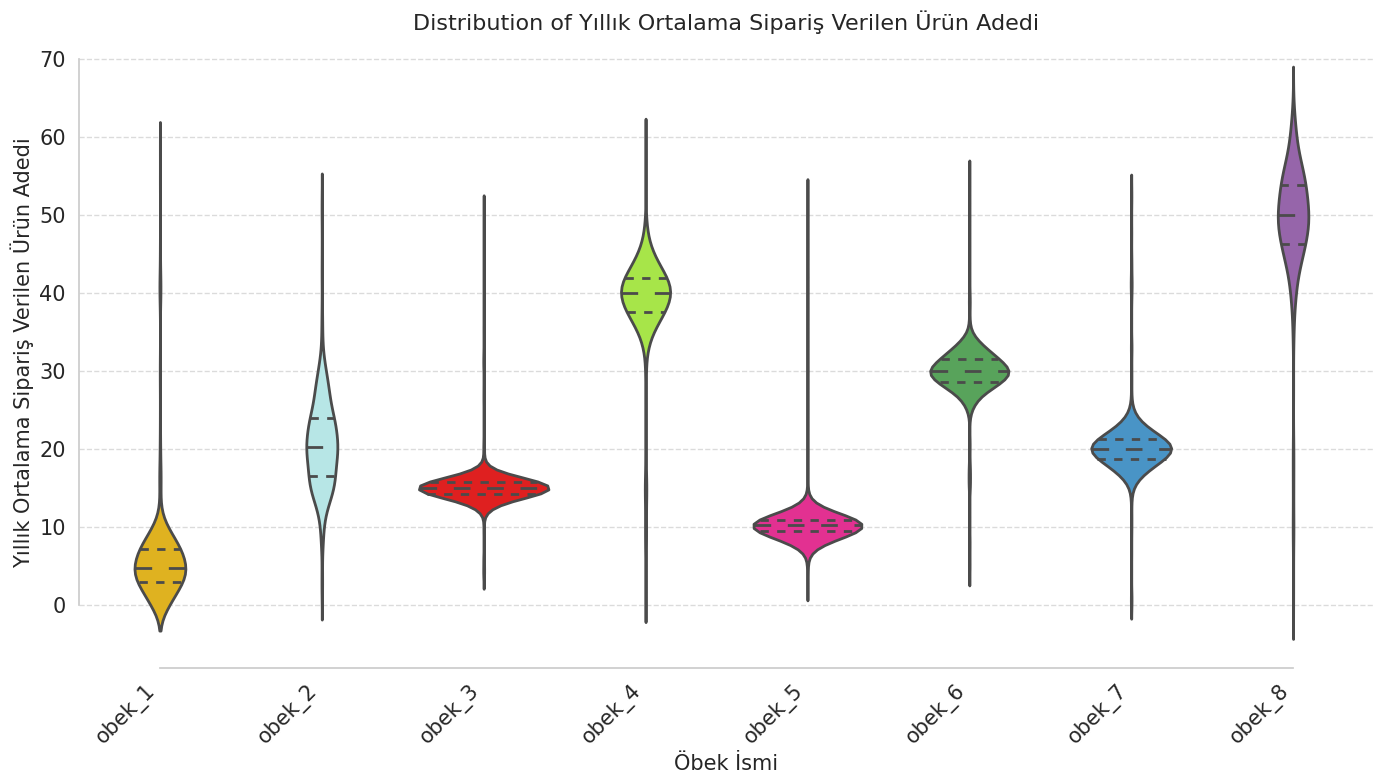


----- Yıllık Ortalama Sepete Atılan Ürün Adedi -----
Min: 3.977558775834797
Mean: 73.44569302866336
Median: 82.48557941901836
Max: 242.30844066611877
Std Dev: 47.2141837101441


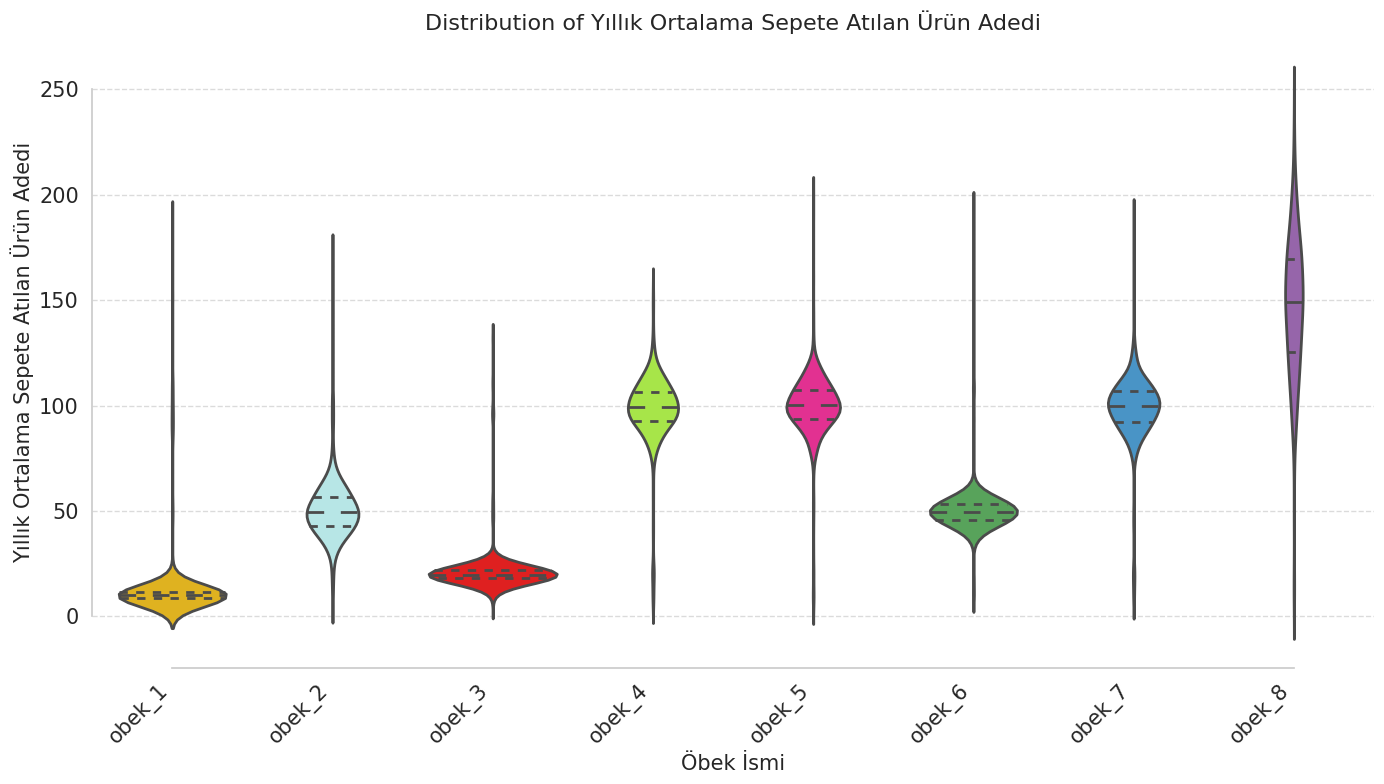

In [ ]:
analyzer.summarize_num_columns()

Categorical kolonlardan edindiğimiz bilgilere ek olarak, numerical kolonlardan elde ettiğimiz violin plotlardaki bilgileri ekleyelim:

- Öbek 1 (çoğunlukla giyim ve kozmetik alışverişi yapıyor, eğitim düzeyi düşük, yaşlar 60'tan genç.) sepete en az ürün atan ve en az ürün satın alan grup.

- Öbek 2 (çoğunlukla evli kadınlardan oluşuyor, giyim ve mobilya alışverişi yapıyorlar, eğitim düzeyi en fazla lise, genellikle işsiz, yaşlar 60'tan genç.) Hem gelirleri düşük hem de pek harcama yapmıyorlar.

- Öbek 3 (her yaştan evli erkekleri içeriyor, kozmetik hariç her şeyi alıyorlar, çoğu lise mezunu, kırsalda pek yaşamıyorlar.) sepete az ürün atıyorlar. 

- Öbek 4 (bekar, 18-40 yaş arası, büyük şehirde yaşayan, en az yüksek okul mezunu, eğitimli kişileri kapsıyor. Her şeyi satın alıyorlar.) Yıllık ortalama geliri en yüksek grup. Ayrıca çok ürün satın alıyorlar, sepete o kadar çok atmamalarına rağmen. Pahalı ürünler alıyor olmalılar.

- Öbek 5 (çoğu 18-40 yaş arası erkek, lise mezunu, kırsalda yaşamayan, aralarında emekli olmayan bir grup insan.) Sepete çok atıyorlar ama satın almıyorlar, gelirleri de düşük.

- Öbek 6 (kırsal, köy ve kasabayı tercih ediyor, çoğu emekli, 51 yaş ve üstü, üniversite mezunu insanlar.) En çok para harcayan grup.

- Öbek 7 (küçük ve büyük şehirlerde yaşıyor, en az üniversite mezunu, düzenli işi var, 18-50 yaş arasında.) Üçüncü çok para harcayan grup.

- Öbek 8 (eğitime devam eden genç kesim.) ortalama sepete en çok ürün atan ve satın alan grup.

# 2) Veri Ön İşleme (preprocessing) ve Özellik Mühendisliği (feature engineering)

Bu İşlemlerin hepsi fonksiyonel hale getirildi. Veri hazırlama işlemi automatize edildi.

In [ ]:
## Preprocessing için yardımcı fonksiyonlar sınıfı

class CheckForOutliers:

    def __init__(self, dataframe):

        self.df = dataframe
    
    def check_outlier(self, col_name):
        """
        Dataframe de aykırı değer var mı yok mu onu kontrol eder istenen col_name kolonunda
        Outlier varsa True, yoksa False return eder
        outlier_thresholds'ta belirlenen eşik değerlere göre belirlenir
        """
        low_limit, up_limit = self.outlier_thresholds(col_name)
        if self.df[(self.df[col_name] > up_limit) | (self.df[col_name] < low_limit)].any(axis=None):
            return True
        else:
            return False

    def outlier_thresholds(self, col_name, q1=0.05, q3=0.95):
        """
        Aykırı değer yani outlier thresholds burada belirlenir
        """
        quartile1 = self.df[col_name].quantile(q1)
        quartile3 = self.df[col_name].quantile(q3)
        interquantile_range = quartile3 - quartile1
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile1 - 1.5 * interquantile_range

        return low_limit, up_limit


### 

## 2.1) Aykırı Değer Analizi

In [ ]:
prep = CheckForOutliers(training_df)

for col in numerical_cols:
    print(col, prep.check_outlier(col))


Yıllık Ortalama Gelir False
Yıllık Ortalama Satın Alım Miktarı False
Yıllık Ortalama Sipariş Verilen Ürün Adedi False
Yıllık Ortalama Sepete Atılan Ürün Adedi False


Ağaç yöntemleri kullanacağımızdan eşik değerler yüksek belirlendi. Outlier bulunmadı numerical featurelara göre. Model eğitimi sırasında neticede veri atılmadı.

## 2.2) Çok Değişkenli Aykırı Değer Analizi (LOF)

[-1.02942965 -0.97988463 -1.05155966 -1.05632515 -0.97669373]


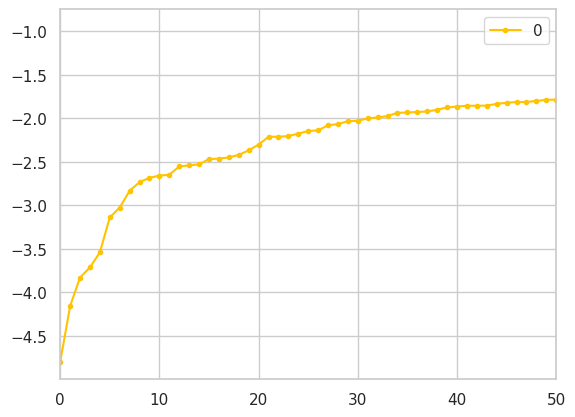

In [ ]:
# Bir de sklearn'ü deneyelim
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(training_df[numerical_cols])
df_scores = clf.negative_outlier_factor_
print(df_scores[0:5])

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked = True,xlim=[0,50],style='.-')
plt.show()

In [ ]:
th = np.sort(df_scores)[5]
training_df[numerical_cols][df_scores<th]

,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi
4204,422025.715497,27418.899652,37.222139,93.811982
4395,302240.117260,26581.049181,17.599960,105.747485
4999,43922.988693,4169.949102,2.934947,10.408325
5100,45695.091498,6740.639692,15.557786,16.284374
5130,299549.793156,27327.309076,19.524385,103.867181


Veri kaybetmemek için outlier detection kısmının sonuçlarını kullanmamaya karar verdik.

## 2.3) Özellik Ekleme Çalışmaları pozitif bazıları negatif etki gösterdi. Model eğitimi ve başarı değerlendirmesinde bunlar tespit edildi.

Çok sayıda yeni öznitelik çıkarıp eklemeyi denedik var olan kolonlara. Bu çalışmalarımız aşağıda. Bazıları bazı modellerde başarılı sonuçlar döndü, bazıları ise diğer modellerde.

In [ ]:
numerical_cols

['Yıllık Ortalama Gelir',
 'Yıllık Ortalama Satın Alım Miktarı',
 'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
 'Yıllık Ortalama Sepete Atılan Ürün Adedi']

In [ ]:
print(f"Yıllık ortalama gelir için %25 çeyreklik değeri: {training_df['Yıllık Ortalama Gelir'].quantile(0.25)}\n"
      f"Yıllık ortalama gelir için %75 çeyreklik değeri: {training_df['Yıllık Ortalama Gelir'].quantile(0.75)}")


Yıllık ortalama gelir için %25 çeyreklik değeri: 215693.43930698355
Yıllık ortalama gelir için %75 çeyreklik değeri: 468188.2217975914


%25 ve %75 quartile değerleri yeterli thresholdlar olarak görünüyor.

In [ ]:

def get_income_group(gelir):

    """
    Yıllık ortalama gelirine göre insanları 3 gruba ayırıyor. 
    Bu threshold değerlerini yukarıdaki cell'deki quartile analizi işlemi ile bulduk
    Buradaki yeni öznitelik modelin validasyon performansını arttırıcı yönde etki etmiştir.
    """

    if gelir < 215693:
        return "Düşük Gelir"
    elif gelir >= 215693 and gelir < 468188:
        return "Orta Gelir"
    else:
        return "Yüksek Gelir"

def gender_age_merge(df):
    """
    Bu önceki fonksiyonlardan farklı olarak, iki kategoriyi birleştirip yeni kategoriler oluşturuyor
    ve tüm dataframe'i input olarak alıyor bunu gerçekleştirmek için.
    Buradaki yeni öznitelik model validasyon performansını arttırıcı yönde etki etmiştir.
    """

    # Cisiyet ve yaş grubu kullanılarak yeni bir özellik oluşturuldu (gender_age)
    df.loc[(df['Cinsiyet'] == 'Erkek') & (df['Yaş Grubu'] == '18-30'), 'gender_age'] = 'genc_erkek'
    df.loc[(df['Cinsiyet'] == 'Erkek') & (df['Yaş Grubu'].isin(['31-40', '41-50'])), 'gender_age'] = 'orta_erkek'
    df.loc[(df['Cinsiyet'] == 'Erkek') & (df['Yaş Grubu'].isin(['51-60', '>60'])), 'gender_age'] = 'yasli_erkek'

    df.loc[(df['Cinsiyet'] == 'Kadın') & (df['Yaş Grubu'] == '18-30'), 'gender_age'] = 'genc_kadin'
    df.loc[(df['Cinsiyet'] == 'Kadın') & (df['Yaş Grubu'].isin(['31-40', '41-50'])), 'gender_age'] = 'orta_kadin'
    df.loc[(df['Cinsiyet'] == 'Kadın') & (df['Yaş Grubu'].isin(['51-60', '>60'])), 'gender_age'] = 'yasli_kadin'

    return df


## 2.4) Encoding, Scaling

In [ ]:
# Veri Ön İşleme İşlemleri İçin Fonksiyonlar

def add_2_new_features(df):

    df["NEW_Gelir_Grubu"] = df["Yıllık Ortalama Gelir"].apply(get_income_group)
    df = gender_age_merge(df)

    return df

def prepare_files_w_extra_2_feats(DIR_, list_cat_cols, list_numerical_cols):
    """
    Validation deneylerimizde extra 2 yeni feature ile bir ensemble modelimiz çok başarılı sonuçlar döndü
    O nedenle bir bu iki extra feature'i içeren ayrı bir fonksiyon yazdık verileri okuyup işleyen
    Otomatize etmemizi sağlıyor bu şekilde işlemleri ve tüm notebooklarımızı birleştirebiliyoruz

    inputs:
        DIR_               : dosyaların bulunduğu directory.
        list_cat_cols      : categorical kolonların isim listesi
        list_numerical_cols: numerical kolonların isim listesi
    """

    # Verileri yeni baştan okuyalım. Çünkü her denemede train_df inplace değişecek
    # Bu fonksiyon her çağırıldığında yeniden okunsun içimiz rahat olsun
    train = pd.read_csv(DIR_ + "train.csv")
    test = pd.read_csv(DIR_ + "test_x.csv") # bunu ilk defa okuyoruz

    train = prepare_df(train)
    test = prepare_df(test) # indeksi bundan da sil

    # Hedef (TARGET) değişken dönüşümü (String'den label numaralarına'e)
    y_labels_str = train[TARGET]
    conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)
    y_labels_num = [conv_str2num_dict[str_] for str_ in y_labels_str]
    
    y_labels_num = np.array(y_labels_num)  # 0,1...7
    train.drop(TARGET, axis=1, inplace = True)

    # İki yeni özniteliği ekle iki sete de
    train = add_2_new_features(train)
    test = add_2_new_features(test)
    
    list_cat_cols.extend(["gender_age", "NEW_Gelir_Grubu"])

    # One Hot Encoder işlemi iki sete de uygulanacak
    train = pd.get_dummies(train, columns = list_cat_cols, drop_first = True)
    test = pd.get_dummies(test, columns = list_cat_cols, drop_first = True)
 
    # Numerik değişlenler için standart normalizasyon işlemi
    scaler = StandardScaler()
    train[list_numerical_cols] = scaler.fit_transform(train[list_numerical_cols])
    test[list_numerical_cols] = scaler.transform(test[list_numerical_cols])

    # Toplam Öbek Sayısı bizim sınıf sayımız
    num_classes = len(set(y_labels_str))

    return train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols


In [ ]:
# Veri Ön İşleme ve Model Öncesi İşlemler
def class_str2num(y_labels_str):

    """
    Hedef değişken dönüşümünde kullanılacak fonksiyon. Bu fonksiyonda öbek_1'i 0 sayısıne çeviriyoruz.
    Çünkü bazı sklearn kütüphaneleri label değerlerinin 0'dan başlamasını istiyor.
    Biz de öbek sayısı - 1 şeklinde tutuyoruz değerleri.

    Input: training setindeki öbek_1, öbek_2... şeklindeki string TARGET değerleri listesi
    Output: bu stringleri sayılara çevirecek, ve sayıları da stringlere çevirecek iki dictionary.
    """

    list_unique = list(set(y_labels_str))
    conv_str2num_dict = {}
    conv_num2str_dict = {}
    
    for str_ in list_unique:
        conv_str2num_dict[str_] = int(str_.split("_")[1])-1
        conv_num2str_dict[int(str_.split("_")[1])-1] = str_
    
    return conv_str2num_dict, conv_num2str_dict

train, y_labels_num, y_labels_str, test, num_classes, categorical_cols = prepare_files_w_extra_2_feats(DIR_, categorical_cols, numerical_cols)

print(train.head(3))

conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)

   Yıllık Ortalama Gelir  Yıllık Ortalama Satın Alım Miktarı  Yıllık Ortalama Sipariş Verilen Ürün Adedi  Yıllık Ortalama Sepete Atılan Ürün Adedi  Cinsiyet_Kadın  Yaş Grubu_31-40  Yaş Grubu_41-50  Yaş Grubu_51-60  Yaş Grubu_>60  Medeni Durum_Evli  Eğitim Düzeyi_Doktora Ötesi  Eğitim Düzeyi_Eğitimsiz  Eğitim Düzeyi_Lise Mezunu  Eğitim Düzeyi_Ortaokul Mezunu  Eğitim Düzeyi_Yüksek Lisans Mezunu  Eğitim Düzeyi_Yüksekokul Mezunu  Eğitim Düzeyi_Üniversite Mezunu  Eğitim Düzeyi_İlkokul Mezunu  \
0               1.751048                            1.091958                                    0.887949                                  0.624683               1                1                0                0              0                  0                            0                        0                          0                              0                                   1                                0                                0                             0   
1         

# 3) Modeller

## 3.1) İlk Model

### Seçilmiş modellerin çağırılması

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore UserWarnings and ConvergenceWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Bu fonksiyon temel modellerin performansını değerlendirir.
# Verilen X verileri ve y hedefleri üzerinde temel sınıflandırma modellerini değerlendirir.
# Sonuçları ekrana yazdırır.
def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    
    # Değerlendirilecek sınıflandırma modellerini ve adlarını içeren bir liste
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        # Çapraz doğrulama ile sınıflandırıcıları 5-fold cross-valiadtion ile değerlendirme
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")
    

base_models(train, y_labels_num)

Base Models....
accuracy: 0.9474 (LR) 
accuracy: 0.9308 (KNN) 
accuracy: 0.9542 (SVC) 
accuracy: 0.8987 (CART) 
accuracy: 0.9546 (RF) 
accuracy: 0.9218 (Adaboost) 
accuracy: 0.946 (GBM) 
accuracy: 0.9522 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 36
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.025953
[LightGBM] [Info] Start training from score -2.047006
[LightGBM] [Info] Start training from score -2.072142
[LightGBM] [Info] Start tr

Base modeller, yani sklearn kütüphanesindeki bu literatürde ve yarışmalarda sık kullanılan makine öğrenmesi yöntemlerinin default parametreleri ile training setinden 5-fold cross-validation sonuçları:

accuracy: 0.9474 (LR) 
accuracy: 0.9308 (KNN) 
accuracy: 0.9542 (SVC) 
accuracy: 0.8993 (CART) 
accuracy: 0.9546 (RF) 
accuracy: 0.9218 (Adaboost) 
accuracy: 0.9467 (GBM) 
accuracy: 0.9522 (XGBoost) 
accuracy: 0.9538 (LightGBM) 

En yüksek crossvalidation sonuçlarını RF, LightGBM dönmüşler. Bu ikisini kesinlikle seçiyoruz. 

Üçüncü yöntem olarak ise (voting için tek sayı lazım bize) KNN'i seçtik. Sonuçları diğer geriye kalan yöntemlerden daha yüksek değil, ama yöntemsel olarak diğerlerinden farklı bir algoritması var. Hipotezimize göre, bu farklı algoritmalı modeli, iki başarılı yöntemle ensemble edersek, iyi genelleyebilen bir model elde ederiz. Çünkü çok sayıda tree-based modeli ensemble etsek de tek bir RF kullansak da pek fark etmez algoritmaları aynı şeyleri bulup duracağı için.

CART ve Adaboost başarısız oldukları için elendi. LR da çok basit kaçardı bu ensemble için. LightGBM varken ensemble'a GBM katmaya gerek duymadık. Burada sadece SVC iyi performans döndüğü halde ensemble'dan elendi. Bunun iki sebebi var. Birincisi, SVC'yi fine-tune etmek diğerlerine göre çok daha uzun sürüyor (önceki proje deneyimlerimizden) hem de tek sayıda modelimiz olmalı. SVC yerine KNN seçtik hızlı olması ve algoritmasının gerçekten çok farklı olması nedeniyle. Clustering problemine benzeyen bu problemde KNN'i ensemble'da kullanmak daha mantıklı geldi bize.

### Hiperparametre Optimizasyonu

Nihayi sonuç olarak en iyi performansı veren modeli KNN-RF-LGBM Stacking Ensemble olarak seçmiştik.

In [ ]:
# Bu fonksiyon, GridSearchCV kullanarak sınıflandırma modellerinin hiperparametrelerini optimize eder.
# Verilen X verileri ve y hedefleri üzerinde modelleri optimize eder.
# Optimizasyon sonuçlarını ekrana yazdırır.
# Optimizasyon sonrası en iyi modelleri döndürür.
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    
    best_models = {}
    
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        
        # Çapraz doğrulama ile sınıflandırıcıları değerlendirme (öncesinde)
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        # GridSearchCV ile en iyi parametreleri bulma ve son modeli oluşturma
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        # Çapraz doğrulama ile sınıflandırıcıları değerlendirme (sonrasında)
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        
        # En iyi modeli bir sözlüğe ekleyerek kaydetme
        best_models[name] = final_model
    
    return best_models



### İlgili Parametre Listelerinin Belirlenmesi

In [ ]:
knn_params = {"n_neighbors": range(1,50)}

rf_params = {    
    'max_depth': [None,10,20]
   }


lightgbm_params = {"learning_rate": [0.01,0.5],
                "n_estimators": [280,300,500],
                'objective': ['multiclass'],
                    'metric': ['multi_logloss'],  # For multiclass classification, 'multi_error' is used with 1 - accuracy
                    'num_class': [8],           # Number of classes in the dataset
                    'boosting_type': ['gbdt'],
                    'num_leaves': [31],
                    'verbose': [0]}


# Parametre optimzasyonunda kullanılacak modeller:
classifiers = [
            ('LightGBM', LGBMClassifier(), lightgbm_params),
            ('KNN', KNeighborsClassifier(), knn_params),
            ("RF", RandomForestClassifier(), rf_params)
            ]


In [ ]:
best_models = hyperparameter_optimization(train, y_labels_num)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
best_models

{'LightGBM': LGBMClassifier(learning_rate=0.01, metric='multi_logloss', n_estimators=500,
                num_class=8, objective='multiclass', verbose=0),
 'KNN': KNeighborsClassifier(n_neighbors=42),
 'RF': RandomForestClassifier()}

En iyi parametreler bunlarmış. Bunlarla devam ederiz artık.

### Stacking & Ensemble Learning

In [ ]:
# Bu fonksiyon, Voting Classifier modelini oluşturur.
# Verilen en iyi modelleri ve verileri kullanarak Voting Classifier'ı oluşturur ve değerlendirir.
# Sonuçları ekrana yazdırır.
def voting_classifier(best_models, X, y):
     print("Voting Classifier...")
     
     # Belirlenen en iyi modelleri kullanarak Voting Classifier'ı oluşturma
     voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                               ('LightGBM', best_models["LightGBM"])],
                                   voting='soft').fit(X, y)
     
     # Çapraz doğrulama ile Voting Classifier'ın performansını değerlendirme
     cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=["accuracy"])

     print(cv_results)
     print("5-fold crossvalidation sonucu:")
     print(f"\n\nMean Accuracy: {cv_results['test_accuracy'].mean()}")
     print(f"STD Accuracy: {cv_results['test_accuracy'].std()}")
     #print(f"F1Score: {cv_results['test_f1'].mean()}")
     
     return voting_clf

In [ ]:
# Modelin Oluşturulması ve Kaydedilmesi
voting_clf = voting_classifier(best_models, train, y_labels_num)
joblib.dump(voting_clf, "lgbm-knn-rf.pkl")

Voting Classifier...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_nam

['lgbm-knn-rf.pkl']

Training set'e uyguladığımız 5-fold crossvalidation'a göre elde ettiğimiz mean accuracy yüksek ve standard deviation da yeterince düşük. Bu ensemble modeli test setine uygulayabiliriz.

### Test Veri Setini Tahmin ve Submission Dosyası Oluşturma

In [ ]:
# Test Veri Setinin Tahmin Edilmesi
predicted = voting_clf.predict(test)

In [ ]:
def convert_test2str(test_res, conv_num2str_dict):
    """
    Test setinden elde edilen prediction sonuçları 0 ile 7 arasındaki sayılar
    Bunları öbek_1, öbek_2 vs. şekline çevirmek için önceki cell'lerde oluşturduğumuz dictionary'e ihtiyaç var
    """
    string_list = [conv_num2str_dict[number] for number in test_res]
    
    return string_list

sample_submission = pd.read_csv(DIR_ + "sample_submission.csv")
sample_submission = sample_submission.iloc[:1].reindex(range(len(predicted)))
sample_submission["id"] = range(len(predicted))
sample_submission[TARGET] = convert_test2str(predicted, conv_num2str_dict)

sample_submission.to_csv('lgbm-knn-rf.csv', index = False) 

Sonuçlar iyi mi kötü mü bilemiyoruz tabi. Yapabileceğimiz en iyi şey, şu noktada başka bir ensemble modelden daha sonuç alıp bunlarla karşılaştırmak. Böylece test seti üzerinden majority voting yapmamız ya da öbeklerin genel karakterlerine göre bir rule geliştirmemiz mümkün olabilir.

## 3.2) İkinci Model

Test seti üzerinden unsupervised voting yani ensemble yapmak mümkün. Buna "bagging ensemble" demişler (L. Breiman, “Bagging predictors,” Machine learning, vol. 24, no. 2, pp. 123–140, 1996.) Biz de bunu uygulamak için, modelleri benzer tutup farklı öznitelikler eklemeyi denemeye karar verdik. Daha fazla öznitelik eklemede yaratıcılığımızı kullandık.

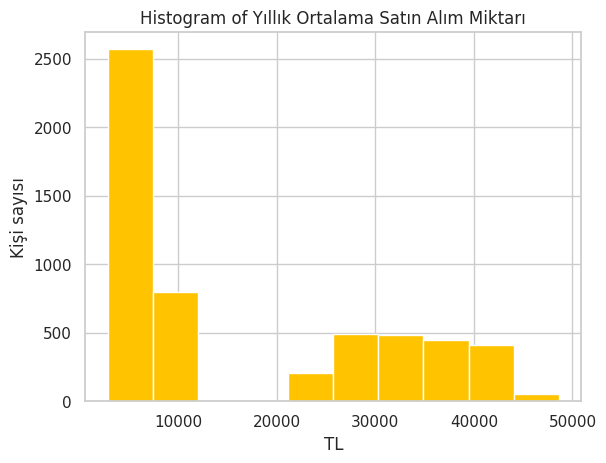

In [ ]:
plt.hist(training_df["Yıllık Ortalama Satın Alım Miktarı"])
plt.title("Histogram of Yıllık Ortalama Satın Alım Miktarı")
plt.xlabel("TL")
plt.ylabel("Kişi sayısı")
plt.show()

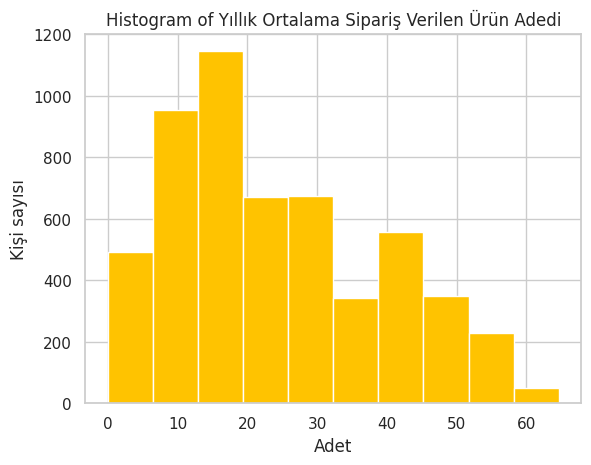

In [ ]:
plt.hist(training_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"])
plt.title("Histogram of Yıllık Ortalama Sipariş Verilen Ürün Adedi")
plt.xlabel("Adet")
plt.ylabel("Kişi sayısı")
plt.show()

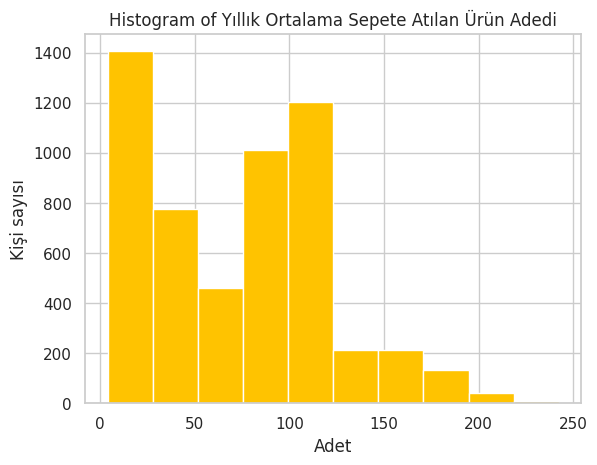

In [ ]:
plt.hist(training_df["Yıllık Ortalama Sepete Atılan Ürün Adedi"])
plt.title("Histogram of Yıllık Ortalama Sepete Atılan Ürün Adedi")
plt.xlabel("Adet")
plt.ylabel("Kişi sayısı")
plt.show()

In [ ]:

def satinalim_grubu(val):
    """
    Ürün satın almada senede kaç para harcadıklarına göre de insanları daha fazla gruplandırdık.
    Threshold değerlerini de değerlerin ortalama değerlerini inceleyerek bulduk.
    """

    if val < 5000:
        return "çok düşük"
    elif val >= 5000 and val < 10000:
        return "az düşük"
    elif val >= 10000 and val < 25000:
        return "orta"
    elif val >= 25000 and val < 40000:
        return "yüksek"
    else:
        return "çok yüksek"

def alisveriskolik_grubu(val):
    """
    Yıllık Ortalama Sipariş Verilen Ürün Adedi kolonundaki değerlere göre gruplandırmak için
    bu fonksiyonu yazdık. Bu değerleri de yine histogramdan inceleyerek seçtik.
    """

    if val < 10:
        return "çok az"
    elif val >= 10 and val < 20:
        return "az"
    elif val >= 20 and val < 30:
        return "normal"
    elif val >= 30 and val < 40:
        return "çok"
    elif val >= 40 and val < 50:
        return "çok çok"
    else:
        return "abartma"

def acgozlu_grubu(val):
    """
    Yıllık Ortalama Sepete Atılan Ürün Adedi kolonundaki değerlere göre gruplandırmak için
    histogram'dan aşağıdaki threshold değerlerini belirledik.
    Sepete atanlara aç gözlü dedik ama aslında hevesli demek daha doğru olur.
    Hangimiz ürünleri sepete atıp atıp, ne kadar tuttuğunu gördükten sonra sepetten çıkarmıyoruz ki?
    """

    if val < 50:
        return "az"
    elif val >= 50 and val < 100:
        return "normal"
    elif val >= 100 and val < 150:
        return "çok"
    else:
        return "acgozlu"

def add_more_features(df):

    # "Yıllık Ortalama Satın Alım Miktarı" değerine göre "satinalim_grubu" fonksiyonunu uygulayarak
    # "NEW_Satin_Alim_Grubu" adlı yeni bir özellik oluştur.
    df["NEW_Satin_Alim_Grubu"] = df["Yıllık Ortalama Satın Alım Miktarı"].apply(satinalim_grubu).tolist()

    # "Yıllık Ortalama Sipariş Verilen Ürün Adedi" değerine göre "alisveriskolik_grubu" fonksiyonunu uygulayarak
    # "NEW_Alisveris_Grubu" adlı yeni bir özellik oluştur.
    df["NEW_Alisveris_Grubu"] = df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"].apply(alisveriskolik_grubu).tolist()

    # "Yıllık Ortalama Sepete Atılan Ürün Adedi" değerine göre "acgozlu_grubu" fonksiyonunu uygulayarak
    # "NEW_Acgozlu_Grubu" adlı yeni bir özellik oluştur.
    df["NEW_Acgozlu_Grubu"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"].apply(acgozlu_grubu).tolist()

    age_dict = {"18-30": 24.0, "31-40": 35.0, "41-50": 45.0, "51-60": 55.0, ">60": 65.0}
    df["NEW_Age"] = [age_dict[str_] for str_ in df["Yaş Grubu"].tolist()]

    return df


In [ ]:
def prepare_files_more_feats(DIR_, list_cat_cols, list_numerical_cols):
    """
    prepare_files_w_extra_2_feats(DIR_, list_cat_cols, list_numerical_cols) bunun bir kopyası sayılır

    Sadece validation deneylerimize daha fazla yeni feature eklemeyi deniyoruz

    inputs:
        DIR_               : dosyaların bulunduğu directory.
        list_cat_cols      : categorical kolonların isim listesi
        list_numerical_cols: numerical kolonların isim listesi
    """

    # Verilerin yeni baştan okunması
    train = pd.read_csv(DIR_ + "train.csv")
    test = pd.read_csv(DIR_ + "test_x.csv")

    train = prepare_df(train)
    test = prepare_df(test) # indeksi bundan da sil

    # Hedef (TARGET) değişken dönüşümü (String'den label numaralarına'e)
    y_labels_str = train[TARGET]
    conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)
    y_labels_num = [conv_str2num_dict[str_] for str_ in y_labels_str]
    
    y_labels_num = np.array(y_labels_num)  # 0,1...7
    train.drop(TARGET, axis=1, inplace = True)

    # İki yeni özniteliği ekle iki sete de
    train = add_more_features(train)
    test = add_more_features(test)

    list_cat_cols.extend(["NEW_Satin_Alim_Grubu", "NEW_Alisveris_Grubu", "NEW_Acgozlu_Grubu"])
    list_numerical_cols.extend(["NEW_Age"])

    # One Hot Encoder işlemi
    train= pd.get_dummies(train, columns=list_cat_cols,drop_first = True)
    test= pd.get_dummies(test, columns=list_cat_cols,drop_first = True)
 
    # Numerik değişlenler için standartlaşdırma işlemi
    scaler = StandardScaler()
    train[list_numerical_cols] = scaler.fit_transform(train[list_numerical_cols])
    test[list_numerical_cols] = scaler.transform(test[list_numerical_cols])

    #Toplam Öbek Sayısı
    num_classes = len(set(y_labels_str))

    return train,y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols



In [ ]:
# Veri Ön İşleme ve Model Öncesi İşlemler
training_df = pd.read_csv(DIR_ + "train.csv")
training_df = prepare_df(training_df)

analyzer = DataframeAnalyzer(training_df)

categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols = prepare_files_more_feats(DIR_, categorical_cols, numerical_cols)
train.head(3)

Number of categorical_cols: 8
Number of numerical_cols: 4


,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi,NEW_Age,Cinsiyet_Kadın,Yaş Grubu_31-40,Yaş Grubu_41-50,Yaş Grubu_51-60,Yaş Grubu_>60,Medeni Durum_Evli,Eğitim Düzeyi_Doktora Ötesi,Eğitim Düzeyi_Eğitimsiz,Eğitim Düzeyi_Lise Mezunu,Eğitim Düzeyi_Ortaokul Mezunu,Eğitim Düzeyi_Yüksek Lisans Mezunu,Eğitim Düzeyi_Yüksekokul Mezunu,Eğitim Düzeyi_Üniversite Mezunu,Eğitim Düzeyi_İlkokul Mezunu,İstihdam Durumu_Emekli,İstihdam Durumu_Kendi İşinin Sahibi,İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok,Yaşadığı Şehir_Köy veya Kasaba,Yaşadığı Şehir_Küçük Şehir,Yaşadığı Şehir_Kırsal,En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya,En Çok İlgilendiği Ürün Grubu_Giyim,En Çok İlgilendiği Ürün Grubu_Kozmetik,En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri,Eğitime Devam Etme Durumu_Etmiyor,NEW_Satin_Alim_Grubu_orta,NEW_Satin_Alim_Grubu_yüksek,NEW_Satin_Alim_Grubu_çok düşük,NEW_Satin_Alim_Grubu_çok yüksek,NEW_Alisveris_Grubu_az,NEW_Alisveris_Grubu_normal,NEW_Alisveris_Grubu_çok,NEW_Alisveris_Grubu_çok az,NEW_Alisveris_Grubu_çok çok,NEW_Acgozlu_Grubu_az,NEW_Acgozlu_Grubu_normal,NEW_Acgozlu_Grubu_çok
0,1.751048,1.091958,0.887949,0.624683,-0.274344,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
1,-0.533799,-0.884593,-0.835505,0.184927,1.880005,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0
2,-0.432366,-0.474698,2.095272,1.444947,-1.064272,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
knn_params = {"n_neighbors": [8]}

rf_params = {"max_depth": [8],
             "max_features": [8],
             "min_samples_split": [15],
             "n_estimators": [300]}


lightgbm_params = {"learning_rate": [0.01],
                   "n_estimators": [300],
                   "colsample_bytree": [0.7, 1],
                   'objective': ['multiclass'],
                    'metric': ['multi_logloss'],  # For multiclass classification, 'multi_error' is used with 1 - accuracy
                    'num_class': [num_classes],           # Number of classes in the dataset
                    'boosting_type': ['gbdt'],
                    'num_leaves': [31],
                    'feature_fraction': [0.9],
                    'bagging_fraction': [0.8],
                    'bagging_freq': [5],
                    'verbose': [0]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               #("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    
    # Değerlendirilecek sınıflandırma modellerini ve adlarını içeren bir liste
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        # Çapraz doğrulama ile sınıflandırıcıları değerlendirme
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(train, y_labels_num)



Base Models....
accuracy: 0.9513 (LR) 
accuracy: 0.9482 (KNN) 
accuracy: 0.9526 (SVC) 
accuracy: 0.8989 (CART) 
accuracy: 0.9544 (RF) 
accuracy: 0.8987 (Adaboost) 
accuracy: 0.9485 (GBM) 
accuracy: 0.9529 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 42
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.025953
[LightGBM] [Info] Start training from score -2.047006
[LightGBM] [Info] Start training from score -2.072142
[LightGBM] [Info] Start t

In [ ]:
best_models = hyperparameter_optimization(train, y_labels_num)

voting_clf_new_feature = voting_classifier(best_models, train, y_labels_num)
joblib.dump(voting_clf_new_feature, "voting_clf_new_feature.pkl")

Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.9482
accuracy (After): 0.9498
KNN best params: {'n_neighbors': 8}

########## RF ##########
accuracy (Before): 0.9542
accuracy (After): 0.9544
RF best params: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 15, 'n_estimators': 300}

########## LightGBM ##########
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 42
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.0259

['voting_clf_new_feature.pkl']

Mean accuracy bir önceki ensemble modelle neredeyse aynı. Sadece dördüncü basamaktan itibaren bir değişim var. Bakalım test setinde etkisi kaç sample üzerinde belli olacak:

In [ ]:
predicted=voting_clf_new_feature.predict(test)

sample_submission = pd.read_csv(DIR_+"sample_submission.csv")
sample_submission = sample_submission.iloc[:1].reindex(range(len(predicted)))
sample_submission["id"] = range(len(predicted))
sample_submission[TARGET] = convert_test2str(predicted, conv_num2str_dict)

sample_submission.to_csv('new_feature_lgbm-knn-rf.csv', index = False) 
sample_submission


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


,id,Öbek İsmi
0,0,obek_3
1,1,obek_3
2,2,obek_2
3,3,obek_6
4,4,obek_1
...,...,...
2335,2335,obek_8
2336,2336,obek_2
2337,2337,obek_7
2338,2338,obek_5


## 3.3) Üçüncü Model

In [ ]:
def add_much_more_features(df):
    df["NEW_Ortalama_TekUrun_Fiyati"] = df["Yıllık Ortalama Satın Alım Miktarı"] / (df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]  + 0.0001)
    df["NEW_Greed"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] / (df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] + 0.0001)
    df["NEW_Greed2"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] - df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    df["NEW_Savings"] = df['Yıllık Ortalama Gelir'] - df['Yıllık Ortalama Satın Alım Miktarı']
    df["NEW_Aylik_Gelir"] = df['Yıllık Ortalama Gelir']/12.0
    df["NEW_Aylik_Satin_Alim"] = df["Yıllık Ortalama Satın Alım Miktarı"] / 12.0

    df["NEW_Gelir_Grubu"] = df["Yıllık Ortalama Gelir"].apply(get_income_group)
    df = gender_age_merge(df)
    df["NEW_Satin_Alim_Grubu"] = df["Yıllık Ortalama Satın Alım Miktarı"].apply(satinalim_grubu).tolist()
    df["NEW_Alisveris_Grubu"] = df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"].apply(alisveriskolik_grubu).tolist()
    df["NEW_Acgozlu_Grubu"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"].apply(acgozlu_grubu).tolist()
    # "Yıllık Ortalama Satın Alım Miktarı" değerini aylık olarak hesaplayarak "NEW_Aylik_Satin_Alim" adlı yeni bir özellik oluştur.

    age_dict = {"18-30": 24.0, "31-40": 35.0, "41-50": 45.0, "51-60": 55.0, ">60": 65.0}

    df["NEW_Age"] = [age_dict[str_] for str_ in df["Yaş Grubu"].tolist()]

    return df

def prepare_files_more_x_feats(DIR_, list_cat_cols, list_numerical_cols):
    """
    prepare_files_w_extra_2_feats(DIR_, list_cat_cols, list_numerical_cols) bunun bir kopyası sayılır

    Sadece validation deneylerimize daha fazla yeni feature eklemeyi deniyoruz

    inputs:
        DIR_               : dosyaların bulunduğu directory.
        list_cat_cols      : categorical kolonların isim listesi
        list_numerical_cols: numerical kolonların isim listesi
    """

    # Verilerin yeni baştan okunması
    train = pd.read_csv(DIR_ + "train.csv")
    test = pd.read_csv(DIR_ + "test_x.csv")

    train = prepare_df(train)
    test = prepare_df(test) # indeksi bundan da sil

    # Hedef (TARGET) değişken dönüşümü (String'den label numaralarına'e)
    y_labels_str = train[TARGET]
    conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)
    y_labels_num = [conv_str2num_dict[str_] for str_ in y_labels_str]
    
    y_labels_num = np.array(y_labels_num)  # 0,1...7
    train.drop(TARGET, axis=1, inplace = True)

    # İki yeni özniteliği ekle iki sete de
    train = add_much_more_features(add_2_new_features(train))
    test = add_much_more_features(add_2_new_features(test))
    
    list_cat_cols.extend(["NEW_Satin_Alim_Grubu", "NEW_Alisveris_Grubu", "NEW_Acgozlu_Grubu", 
                            "NEW_Gelir_Grubu", "gender_age"])
    list_numerical_cols.extend(["NEW_Ortalama_TekUrun_Fiyati", "NEW_Greed", "NEW_Greed2", "NEW_Savings",
                                "NEW_Aylik_Gelir", "NEW_Aylik_Satin_Alim", "NEW_Age"])


    # One Hot Encoder işlemi
    train= pd.get_dummies(train, columns=list_cat_cols,drop_first = True)
    test= pd.get_dummies(test, columns=list_cat_cols,drop_first = True)
 
    # Numerik değişlenler için standartlaşdırma işlemi
    scaler = StandardScaler()
    train[list_numerical_cols] = scaler.fit_transform(train[list_numerical_cols])
    test[list_numerical_cols] = scaler.transform(test[list_numerical_cols])

    #Toplam Öbek Sayısı
    num_classes = len(set(y_labels_str))

    return train,y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols



In [ ]:
training_df = pd.read_csv(DIR_ + "train.csv")
training_df = prepare_df(training_df)

analyzer = DataframeAnalyzer(training_df)

categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols = prepare_files_more_x_feats(DIR_, categorical_cols, numerical_cols)
train.head(3)

Number of categorical_cols: 8
Number of numerical_cols: 4


,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi,NEW_Ortalama_TekUrun_Fiyati,NEW_Greed,NEW_Greed2,NEW_Savings,NEW_Aylik_Gelir,NEW_Aylik_Satin_Alim,NEW_Age,Cinsiyet_Kadın,Yaş Grubu_31-40,Yaş Grubu_41-50,Yaş Grubu_51-60,Yaş Grubu_>60,Medeni Durum_Evli,Eğitim Düzeyi_Doktora Ötesi,Eğitim Düzeyi_Eğitimsiz,Eğitim Düzeyi_Lise Mezunu,Eğitim Düzeyi_Ortaokul Mezunu,Eğitim Düzeyi_Yüksek Lisans Mezunu,Eğitim Düzeyi_Yüksekokul Mezunu,Eğitim Düzeyi_Üniversite Mezunu,Eğitim Düzeyi_İlkokul Mezunu,İstihdam Durumu_Emekli,İstihdam Durumu_Kendi İşinin Sahibi,İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok,Yaşadığı Şehir_Köy veya Kasaba,Yaşadığı Şehir_Küçük Şehir,Yaşadığı Şehir_Kırsal,En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya,En Çok İlgilendiği Ürün Grubu_Giyim,En Çok İlgilendiği Ürün Grubu_Kozmetik,En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri,Eğitime Devam Etme Durumu_Etmiyor,NEW_Satin_Alim_Grubu_orta,NEW_Satin_Alim_Grubu_yüksek,NEW_Satin_Alim_Grubu_çok düşük,NEW_Satin_Alim_Grubu_çok yüksek,NEW_Alisveris_Grubu_az,NEW_Alisveris_Grubu_normal,NEW_Alisveris_Grubu_çok,NEW_Alisveris_Grubu_çok az,NEW_Alisveris_Grubu_çok çok,NEW_Acgozlu_Grubu_az,NEW_Acgozlu_Grubu_normal,NEW_Acgozlu_Grubu_çok,NEW_Gelir_Grubu_Orta Gelir,NEW_Gelir_Grubu_Yüksek Gelir,gender_age_genc_kadin,gender_age_orta_erkek,gender_age_orta_kadin,gender_age_yasli_erkek,gender_age_yasli_kadin
0,1.751048,1.091958,0.887949,0.624683,-0.084428,-0.083886,0.415854,1.763000,1.751048,1.091958,-0.274344,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
1,-0.533799,-0.884593,-0.835505,0.184927,-0.084539,-0.083363,0.543905,-0.500311,-0.533799,-0.884593,1.880005,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2,-0.432366,-0.474698,2.095272,1.444947,-0.084580,-0.083910,0.946058,-0.421516,-0.432366,-0.474698,-1.064272,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [ ]:
knn_params = {"n_neighbors": [8]}

rf_params = {"max_depth": [8],
             "max_features": [8],
             "min_samples_split": [15],
             "n_estimators": [300]}


lightgbm_params = {"learning_rate": [0.01],
                   "n_estimators": [300],
                   "colsample_bytree": [0.7, 1],
                   'objective': ['multiclass'],
                    'metric': ['multi_logloss'],  # For multiclass classification, 'multi_error' is used with 1 - accuracy
                    'num_class': [num_classes],           # Number of classes in the dataset
                    'boosting_type': ['gbdt'],
                    'num_leaves': [31],
                    'feature_fraction': [0.9],
                    'bagging_fraction': [0.8],
                    'bagging_freq': [5],
                    'verbose': [0]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               #("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    
    # Değerlendirilecek sınıflandırma modellerini ve adlarını içeren bir liste
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        # Çapraz doğrulama ile sınıflandırıcıları değerlendirme
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(train, y_labels_num)



Base Models....
accuracy: 0.9504 (LR) 
accuracy: 0.9513 (KNN) 
accuracy: 0.9524 (SVC) 
accuracy: 0.8995 (CART) 
accuracy: 0.9546 (RF) 
accuracy: 0.891 (Adaboost) 
accuracy: 0.9465 (GBM) 
accuracy: 0.9529 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 55
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.025953
[LightGBM] [Info] Start training from score -2.047006
[LightGBM] [Info] Start training from score -2.072142
[LightGBM] [Info] Start tr

In [ ]:
best_models = hyperparameter_optimization(train, y_labels_num)

voting_clf_new_feature = voting_classifier(best_models, train, y_labels_num)
joblib.dump(voting_clf_new_feature, "voting3_clf_new_feature.pkl")


Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.9513
accuracy (After): 0.9518
KNN best params: {'n_neighbors': 8}

########## RF ##########
accuracy (Before): 0.9544
accuracy (After): 0.9546
RF best params: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 15, 'n_estimators': 300}

########## LightGBM ##########
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 55
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.0259

['voting3_clf_new_feature.pkl']

In [ ]:
predicted=voting_clf_new_feature.predict(test)

sample_submission = pd.read_csv(DIR_+"sample_submission.csv")
sample_submission = sample_submission.iloc[:1].reindex(range(len(predicted)))
sample_submission["id"] = range(len(predicted))
sample_submission[TARGET] = convert_test2str(predicted, conv_num2str_dict)

sample_submission.to_csv('new_extra_feature_lgbm-knn-rf.csv', index = False) 
sample_submission


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


,id,Öbek İsmi
0,0,obek_3
1,1,obek_3
2,2,obek_2
3,3,obek_6
4,4,obek_1
...,...,...
2335,2335,obek_8
2336,2336,obek_2
2337,2337,obek_7
2338,2338,obek_5


## 4) Bagging Ensemble & Human-in-the-loop

Bu ensemble tamamen unsupervised oluyor. İki texst seti sonucunu karşılaştıralım, bakalım ne kadar fark var aralarında:

In [ ]:
def get_different_samples(df1, df2):
    different_filter = df1 != df2
    a = pd.DataFrame()
    
    for column in df1.columns:
        different_values_in_column = different_filter[column]
        a[f"1.DF - {column}"] = df1[column][different_values_in_column]
        a[f"2.DF - {column}"] = df2[column][different_values_in_column]
        
    return a 

model1 = pd.read_csv("lgbm-knn-rf.csv")
model2 = pd.read_csv('new_feature_lgbm-knn-rf.csv')

diff_df = get_different_samples(df1, df2)

diff_df

,1.DF - id,2.DF - id,1.DF - Öbek İsmi,2.DF - Öbek İsmi
158,NaN,NaN,obek_1,obek_3
866,NaN,NaN,obek_1,obek_3
977,NaN,NaN,obek_2,obek_5
1332,NaN,NaN,obek_1,obek_3


In [ ]:
def get_different_samples(df1, df2):
    different_filter = df1 != df2
    a = pd.DataFrame()
    
    for column in df1.columns:
        different_values_in_column = different_filter[column]
        a[f"1.DF - {column}"] = df1[column][different_values_in_column]
        a[f"2.DF - {column}"] = df2[column][different_values_in_column]
        
    return a 

model1 = pd.read_csv("lgbm-knn-rf.csv")
model3 = pd.read_csv('new_extra_feature_lgbm-knn-rf.csv')

diff_df = get_different_samples(df1, df2)

diff_df

,1.DF - id,2.DF - id,1.DF - Öbek İsmi,2.DF - Öbek İsmi
158,NaN,NaN,obek_1,obek_3
866,NaN,NaN,obek_1,obek_3
977,NaN,NaN,obek_2,obek_5
1332,NaN,NaN,obek_1,obek_3
1787,NaN,NaN,obek_2,obek_5


In [ ]:
def get_different_samples(df1, df2):
    different_filter = df1 != df2
    a = pd.DataFrame()
    
    for column in df1.columns:
        different_values_in_column = different_filter[column]
        a[f"1.DF - {column}"] = df1[column][different_values_in_column]
        a[f"2.DF - {column}"] = df2[column][different_values_in_column]
        
    return a 

model2 = pd.read_csv("new_feature_lgbm-knn-rf.csv")
model3 = pd.read_csv('new_extra_feature_lgbm-knn-rf.csv')

diff_df = get_different_samples(df1, df2)

diff_df

,1.DF - id,2.DF - id,1.DF - Öbek İsmi,2.DF - Öbek İsmi
1787,NaN,NaN,obek_2,obek_5


İki sınıflandırma sonucunun crossvalidation sonuçları neredeyse aynıyken, test sonuçları arasında 5 adet sample farklı sınıflandırılmış. Maority voting'e göre 1787 numaralı sample aslında obek_2 olarak sınıflandırılıyor 3 modelden 2si tarafından. O nedenle bunu obek_2 olarak eliyoruz.

Diğer sınıflandırma sonuçlarında new_feature_lgbm-knn-rf ile new_extra_feature_lgbm-knn-rf yöntemlerinin sonuçlarının %100 aynı olması ise bizi ikna edemiyor özniteliklerin çok benzemesi nedeniyle.

 İlginç şekilde birinci modelin öbek_1 dediğine ikinci model öbek_3 demiş. Birinci modelin öbek_2 dediğine ise ikinci model öbek_5 demiş. 1 ile 3, 2 ile 5 karışmış. Öbeklerin açıklamalarını şöyle yapmıştık:

- Öbek 1 (çoğunlukla giyim ve kozmetik alışverişi yapıyor, eğitim düzeyi düşük, yaşlar 60'tan genç.) sepete en az ürün atan ve en az ürün satın alan grup.

- Öbek 3 (her yaştan evli erkekleri içeriyor, kozmetik hariç her şeyi alıyorlar, çoğu lise mezunu, kırsalda pek yaşamıyorlar.) sepete az ürün atıyorlar. 

- Öbek 2 (çoğunlukla evli kadınlardan oluşuyor, giyim ve mobilya alışverişi yapıyorlar, eğitim düzeyi en fazla lise, genellikle işsiz, yaşlar 60'tan genç.) Hem gelirleri düşük hem de pek harcama yapmıyorlar.

- Öbek 5 (çoğu 18-40 yaş arası erkek, lise mezunu, kırsalda yaşamayan, aralarında emekli olmayan bir grup insan.) Sepete çok atıyorlar ama satın almıyorlar, gelirleri de düşük.

Bakalım testteki içeriklerine:

In [ ]:
test_raw = pd.read_csv(DIR_ + "test_x.csv")

# final submission'ımız model1'in kopyası olsun (validation'da en yüksek 5-fold crossvalidation sonucunu o verdi)
final_submission = model1.copy()

In [ ]:
test_raw.iloc[158] # 1 ile 3 karışmış.
# (obek_1 ve obek_3'ün eğitim düzeyleri düşük. obek_1'de kadın çoğunluktu ama erkekler de vardı. 
# En çok giyim alışverişi yapan gruptu obek_1.
# obek_3 ise erkek çoğunluktu ve eğitim düzeyi liseydi. Bu grup herşeyi satın alıyordu kozmetik hariç. 
# Yani kategorik bilgilere göre bu kişinin iki gruba da ait olması mantıklı gelmiyor. O nedenle sayısal verilerin
# kolonlarına bakıyoruz. Violin plot'lara göre iki öbek arasında en açık fark 
# "Yıllık Ortalama Sipariş Verilen Ürün Adedi". obek_3'te bu değer 15 civarı ortalamayken, obek_1 10 civarı, 
# 12'lere çıkıyor ve daha yükselmiyor. O nedenle bu kişi için de Model1 sonucuna güveneceğiz. )

index                                                                    158
Cinsiyet                                                               Erkek
Yaş Grubu                                                              51-60
Medeni Durum                                                            Evli
Eğitim Düzeyi                                                 Doktora Mezunu
İstihdam Durumu                               Düzenli ve Ücretli Bir İşi Var
Yıllık Ortalama Gelir                                          203304.492896
Yaşadığı Şehir                                                   Küçük Şehir
En Çok İlgilendiği Ürün Grubu                                          Giyim
Yıllık Ortalama Satın Alım Miktarı                                5798.36523
Yıllık Ortalama Sipariş Verilen Ürün Adedi                         12.058319
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           14.281226

In [ ]:
print(test_raw.iloc[866]) # 1 ile 3 karışmış.
# obek_1 genç bir gruptu, oysa obek_3'te farklı yaş grupları oranları daha yüksekti obek_1'e göre.
# sepete atılan ürün sayısı ile sipariş edilen tamamen aynı değer, yani kişi sepete attığını alıyor.
# aynı zamanda sipariş sayıları da az. Bu kişiyi sınıflandırmak çok zor. Ek analiz lazım.

train_raw = pd.read_csv(DIR_ + "train.csv")
print(train_raw[(train_raw["Yaş Grubu"] == ">60") & 
     (train_raw["Cinsiyet"] == "Erkek") & 
     (train_raw[TARGET] == "obek_1") & 
     (~train_raw["Eğitim Düzeyi"].isin(["Yüksek Lisans Mezunu", "Üniversite Mezunu", "Doktora Ötesi", 
                                        "Doktora Mezunu", "Yüksekokul Mezunu"]))])

print("\n")
print(train_raw[(train_raw["Yaş Grubu"] == ">60") & 
     (train_raw["Cinsiyet"] == "Erkek") & 
     (train_raw[TARGET] == "obek_3") & 
     (~train_raw["Eğitim Düzeyi"].isin(["Yüksek Lisans Mezunu", "Üniversite Mezunu", "Doktora Ötesi", 
                                        "Doktora Mezunu", "Yüksekokul Mezunu"]))])

# Yaş, cinsiyet ve eğitim düzeyi kriterlerine göre, obek_3'te 90 kişi, obek_1'de ise 15 kişi bulundu.
# Sadece bu kişiyi Model2 ya da Model3 sonucu ile işaretleyebiliriz.
final_submission[TARGET][866] = model2[TARGET][866]

index                                                                    866
Cinsiyet                                                               Erkek
Yaş Grubu                                                                >60
Medeni Durum                                                           Bekar
Eğitim Düzeyi                                                 İlkokul Mezunu
İstihdam Durumu                               İşsiz veya Düzenli Bir İşi Yok
Yıllık Ortalama Gelir                                          358624.163245
Yaşadığı Şehir                                                   Büyük Şehir
En Çok İlgilendiği Ürün Grubu                                          Giyim
Yıllık Ortalama Satın Alım Miktarı                               5709.280131
Yıllık Ortalama Sipariş Verilen Ürün Adedi                         11.578165
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           11.578165

In [ ]:
test_raw.iloc[977] # 2 ile 5 karışmış.
# (obek_2 giyim alışverişi yapan işsiz kadınları içeriyordu, ev hanımları gibi. obek_5 ise erkek çoğunluktu.
# bu kişi obek_2 olmalı. burada da Model1 sonucuna daha çok güveniyorum)

index                                                                    977
Cinsiyet                                                               Kadın
Yaş Grubu                                                              18-30
Medeni Durum                                                           Bekar
Eğitim Düzeyi                                                    Lise Mezunu
İstihdam Durumu                               İşsiz veya Düzenli Bir İşi Yok
Yıllık Ortalama Gelir                                          165832.516134
Yaşadığı Şehir                                               Köy veya Kasaba
En Çok İlgilendiği Ürün Grubu                                          Giyim
Yıllık Ortalama Satın Alım Miktarı                               4144.014521
Yıllık Ortalama Sipariş Verilen Ürün Adedi                          8.708317
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           69.294935

In [ ]:
test_raw.iloc[1332] # 1 ile 3 karışmış. 
# (obek_1 kozmetik alıyor, obek_3 ise almıyordu. bu obek_1 olmalı. Model1 sonucuna güveniyorum bu örnekte)

index                                                                   1332
Cinsiyet                                                               Erkek
Yaş Grubu                                                              18-30
Medeni Durum                                                            Evli
Eğitim Düzeyi                                                 İlkokul Mezunu
İstihdam Durumu                               Düzenli ve Ücretli Bir İşi Var
Yıllık Ortalama Gelir                                          232040.391483
Yaşadığı Şehir                                                   Büyük Şehir
En Çok İlgilendiği Ürün Grubu                                       Kozmetik
Yıllık Ortalama Satın Alım Miktarı                               5764.448897
Yıllık Ortalama Sipariş Verilen Ürün Adedi                         11.749308
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           13.651035

Human-intervention sürecinde Model1 sonuçlarına göre sadece tek bir verinin sonucunu Model2 ya da Model3 sonucu ile değiştirmiş olduk. Artık bu dosyayı save edip submission için hazırlayabiliriz:

In [ ]:
final_submission.to_csv("Ensamble-rf-knn-lgbm.csv", index=False)

# Bu sonuç ile public test setinde Score: 0.96195
# private test setinde Private score: 0.95200

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=88d435bb-04e3-4b54-a36b-59ced22d48e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>